## Dependencies

In [1]:
import re
import warnings
import tensorflow_hub as hub
from nltk.corpus import stopwords
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from googleqa_utilityscript import *


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Load data

In [2]:
hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

## Pre-process data

In [4]:
misspelling_mapping = {'sb91': 'senate bill', 'trump': 'trump', 'utmterm': 'utm term', 'fakenews': 'fake news', 'gʀᴇat': 'great', 'ʙᴏᴛtoᴍ': 'bottom', 'washingtontimes': 'washington times', 
                       'garycrum': 'gary crum', 'htmlutmterm': 'html utm term', 'rangermc': 'car', 'tfws': 'tuition fee waiver', 'sjws': 'social justice warrior', 'koncerned': 'concerned', 
                       'vinis': 'vinys', 'yᴏᴜ': 'you', 'trumpsters': 'trump', 'trumpian': 'trump', 'bigly': 'big league', 'trumpism': 'trump', 'yoyou': 'you', 'auwe': 'wonder', 
                       'drumpf': 'trump', 'brexit': 'british exit', 'utilitas': 'utilities', 'ᴀ': 'a', '😉': 'wink', '😂': 'joy', '😀': 'stuck out tongue', 'theguardian': 'the guardian', 
                       'deplorables': 'deplorable', 'theglobeandmail': 'the globe and mail', 'justiciaries': 'justiciary', 'creditdation': 'accreditation', 'doctrne': 'doctrine', 
                       'fentayal': 'fentanyl', 'designation-': 'designation', 'conartist': 'con-artist', 'mutilitated': 'mutilated', 'obumblers': 'bumblers', 
                       'negotiatiations': 'negotiations', 'dood-': 'dood', 'irakis': 'iraki', 'cooerate': 'cooperate', 'cox': 'cox', 'racistcomments': 'racist comments', 
                       'envirnmetalists': 'environmentalists', 'abandonned': 'abandoned', 'aberation': 'aberration', 'abilties': 'abilities', 'abilty': 'ability', 'abondon': 'abandon', 
                       'abbout': 'about', 'abotu': 'about', 'abouta': 'about a', 'aboutit': 'about it', 'aboutthe': 'about the', 'abscence': 'absence', 'abondoned': 'abandoned', 
                       'abondoning': 'abandoning', 'abondons': 'abandons', 'aborigene': 'aborigine', 'accesories': 'accessories', 'accidant': 'accident', 'abortificant': 'abortifacient', 
                       'abreviate': 'abbreviate', 'abreviated': 'abbreviated', 'abreviation': 'abbreviation', 'abritrary': 'arbitrary', 'absail': 'abseil', 'absailing': 'abseiling', 
                       'absense': 'absence', 'absolutly': 'absolutely', 'absorbsion': 'absorption', 'absorbtion': 'absorption', 'abudance': 'abundance', 'abundacies': 'abundances', 
                       'abundancies': 'abundances', 'abundunt': 'abundant', 'abutts': 'abuts', 'acadamy': 'academy', 'acadmic': 'academic', 'accademic': 'academic', 'accademy': 'academy', 
                       'acccused': 'accused', 'accelleration': 'acceleration', 'accension': 'accession', 'acceptence': 'acceptance', 'acceptible': 'acceptable', 'accessable': 'accessible', 
                       'accidentaly': 'accidentally', 'accidently': 'accidentally', 'acclimitization': 'acclimatization', 'accomadate': 'accommodate', 'accomadated': 'accommodated', 
                       'accomadates': 'accommodates', 'accomadating': 'accommodating', 'accomadation': 'accommodation', 'accomadations': 'accommodations', 'accomdate': 'accommodate', 
                       'accomodate': 'accommodate', 'accomodated': 'accommodated', 'accomodates': 'accommodates', 'accomodating': 'accommodating', 'accomodation': 'accommodation', 
                       'accomodations': 'accommodations', 'accompanyed': 'accompanied', 'accordeon': 'accordion', 'accordian': 'accordion', 'accoring': 'according', 
                       'accoustic': 'acoustic', 'accquainted': 'acquainted', 'accrediation': 'accreditation', 'accredidation': 'accreditation', 'accross': 'across', 'accussed': 'accused', 
                       'acedemic': 'academic', 'acheive': 'achieve', 'acheived': 'achieved', 'acheivement': 'achievement', 'acheivements': 'achievements', 'acheives': 'achieves', 
                       'acheiving': 'achieving', 'acheivment': 'achievement', 'acheivments': 'achievements', 'achievment': 'achievement', 'achievments': 'achievements', 
                       'achive': 'achieve', 'achived': 'achieved', 'achivement': 'achievement', 'achivements': 'achievements', 'acident': 'accident', 'acknowldeged': 'acknowledged', 
                       'acknowledgeing': 'acknowledging', 'ackward': 'awkward', 'acommodate': 'accommodate', 'acomplish': 'accomplish', 'acomplished': 'accomplished', 
                       'acomplishment': 'accomplishment', 'acomplishments': 'accomplishments', 'acording': 'according', 'acordingly': 'accordingly', 'acquaintence': 'acquaintance', 
                       'acquaintences': 'acquaintances', 'acquiantence': 'acquaintance', 'acquiantences': 'acquaintances', 'acquited': 'acquitted', 'activites': 'activities', 
                       'activly': 'actively', 'actualy': 'actually', 'acuracy': 'accuracy', 'acused': 'accused', 'acustom': 'accustom', 'acustommed': 'accustomed', 'adavanced': 'advanced', 
                       'adbandon': 'abandon', 'addional': 'additional', 'addionally': 'additionally', 'additinally': 'additionally', 'additionaly': 'additionally', 
                       'additonal': 'additional', 'additonally': 'additionally', 'addmission': 'admission', 'addopt': 'adopt', 'addopted': 'adopted', 'addoptive': 'adoptive', 
                       'addres': 'address', 'addresable': 'addressable', 'addresed': 'addressed', 'addresing': 'addressing', 'addressess': 'addresses', 'addtion': 'addition', 
                       'addtional': 'additional', 'adecuate': 'adequate', 'adequit': 'adequate', 'adhearing': 'adhering', 'adherance': 'adherence', 'admendment': 'amendment', 
                       'admininistrative': 'administrative', 'adminstered': 'administered', 'adminstrate': 'administrate', 'adminstration': 'administration', 
                       'adminstrative': 'administrative', 'adminstrator': 'administrator', 'admissability': 'admissibility', 'admissable': 'admissible', 'admited': 'admitted', 
                       'admitedly': 'admittedly', 'adn': 'and', 'adolecent': 'adolescent', 'adquire': 'acquire', 'adquired': 'acquired', 'adquires': 'acquires', 'adquiring': 'acquiring', 
                       'adres': 'address', 'adresable': 'addressable', 'adresing': 'addressing', 'adress': 'address', 'adressable': 'addressable', 'adressed': 'addressed', 
                       'adressing': 'addressing', 'adventrous': 'adventurous', 'advertisment': 'advertisement', 'advertisments': 'advertisements', 'advesary': 'adversary', 'adviced': 'advised', 'aeriel': 'aerial', 'aeriels': 'aerials', 'afair': 'affair', 'afficianados': 'aficionados', 'afficionado': 'aficionado', 'afficionados': 'aficionados', 'affilate': 'affiliate', 'affilliate': 'affiliate', 'affort': 'afford', 'aforememtioned': 'aforementioned', 'againnst': 'against', 'agains': 'against', 'agaisnt': 'against', 'aganist': 'against', 'aggaravates': 'aggravates', 'aggreed': 'agreed', 'aggreement': 'agreement', 'aggregious': 'egregious', 'aggresive': 'aggressive', 'agian': 'again', 'agianst': 'against', 'agin': 'again', 'agina': 'again', 'aginst': 'against', 'agravate': 'aggravate', 'agre': 'agree', 'agred': 'agreed', 'agreeement': 'agreement', 'agreemnt': 'agreement', 'agregate': 'aggregate', 'agregates': 'aggregates', 'agreing': 'agreeing', 'agression': 'aggression', 'agressive': 'aggressive', 'agressively': 'aggressively', 'agressor': 'aggressor', 'agricultue': 'agriculture', 'agriculure': 'agriculture', 'agricuture': 'agriculture', 'agrieved': 'aggrieved', 'ahev': 'have', 'ahppen': 'happen', 'ahve': 'have', 'aicraft': 'aircraft', 'aiport': 'airport', 'airbourne': 'airborne', 'aircaft': 'aircraft', 'aircrafts': 'aircraft', 'airporta': 'airports', 'airrcraft': 'aircraft', 'aisian': 'asian', 'albiet': 'albeit', 'alchohol': 'alcohol', 'alchoholic': 'alcoholic', 'alchol': 'alcohol', 'alcholic': 'alcoholic', 'alcohal': 'alcohol', 'alcoholical': 'alcoholic', 'aledge': 'allege', 'aledged': 'alleged', 'aledges': 'alleges', 'alege': 'allege', 'aleged': 'alleged', 'alegience': 'allegiance', 'algebraical': 'algebraic', 'algorhitms': 'algorithms', 'algoritm': 'algorithm', 'algoritms': 'algorithms', 'alientating': 'alienating', 'alledge': 'allege', 'alledged': 'alleged', 'alledgedly': 'allegedly', 'alledges': 'alleges', 'allegedely': 'allegedly', 'allegedy': 'allegedly', 'allegely': 'allegedly', 'allegence': 'allegiance', 'allegience': 'allegiance', 'allign': 'align', 'alligned': 'aligned', 'alliviate': 'alleviate', 'allopone': 'allophone', 'allopones': 'allophones', 'allready': 'already', 'allthough': 'although', 'alltime': 'all-time', 'alltogether': 'altogether', 'almsot': 'almost', 'alochol': 'alcohol', 'alomst': 'almost', 'alot': 'a lot', 'alotted': 'allotted', 'alowed': 'allowed', 'alowing': 'allowing', 'alreayd': 'already', 'alse': 'else', 'alsot': 'also', 'alternitives': 'alternatives', 'altho': 'although', 'althought': 'although', 'altough': 'although', 'alusion': 'allusion', 'alwasy': 'always', 'alwyas': 'always', 'amalgomated': 'amalgamated', 'amatuer': 'amateur', 'amature': 'armature', 'amendmant': 'amendment', 'Amercia': 'America', 'amerliorate': 'ameliorate', 'amke': 'make', 'amking': 'making', 'ammend': 'amend', 'ammended': 'amended', 'ammendment': 'amendment', 'ammendments': 'amendments', 'ammount': 'amount', 'ammused': 'amused', 'amoung': 'among', 'amoungst': 'amongst', 'amung': 'among', 'amunition': 'ammunition', 'analagous': 'analogous', 'analitic': 'analytic', 'analogeous': 'analogous', 'anarchim': 'anarchism', 'anarchistm': 'anarchism', 'anbd': 'and', 'ancestory': 'ancestry', 'ancilliary': 'ancillary', 'andd': 'and', 'androgenous': 'androgynous', 'androgeny': 'androgyny', 'anihilation': 'annihilation', 'aniversary': 'anniversary', 'annoint': 'anoint', 'annointed': 'anointed', 'annointing': 'anointing', 'annoints': 'anoints', 'annouced': 'announced', 'annualy': 'annually', 'annuled': 'annulled', 'anohter': 'another', 'anomolies': 'anomalies', 'anomolous': 'anomalous', 'anomoly': 'anomaly', 'anonimity': 'anonymity', 'anounced': 'announced', 'anouncement': 'announcement', 'ansalisation': 'nasalisation', 'ansalization': 'nasalization', 'ansestors': 'ancestors', 'antartic': 'antarctic', 'anthromorphization': 'anthropomorphization', 'anthropolgist': 'anthropologist', 'anthropolgy': 'anthropology', 'anual': 'annual', 'anulled': 'annulled', 'anwsered': 'answered', 'anyhwere': 'anywhere', 'anyother': 'any other', 'anytying': 'anything', 'aparent': 'apparent', 'aparment': 'apartment', 'apenines': 'apennines', 'aplication': 'application', 'aplied': 'applied', 'apolegetics': 'apologetics', 'apon': 'upon', 'apparant': 'apparent', 'apparantly': 'apparently', 'appart': 'apart', 'appartment': 'apartment', 'appartments': 'apartments', 'appealling': 'appealing', 'appeareance': 'appearance', 'appearence': 'appearance', 'appearences': 'appearances', 'appenines': 'apennines', 'apperance': 'appearance', 'apperances': 'appearances', 'appereance': 'appearance', 'appereances': 'appearances', 'applicaiton': 'application', 'applicaitons': 'applications', 'appologies': 'apologies', 'appology': 'apology', 'apprearance': 'appearance', 'apprieciate': 'appreciate', 'approachs': 'approaches', 'appropiate': 'appropriate', 'appropraite': 'appropriate', 'appropropiate': 'appropriate', 'approproximate': 'approximate', 'approxamately': 'approximately', 'approxiately': 'approximately', 'approximitely': 'approximately', 'aprehensive': 'apprehensive', 'apropriate': 'appropriate', 'apropriately': 'appropriately', 'aproval': 'approval', 'aproximate': 'approximate', 'aproximately': 'approximately', 'aquaduct': 'aqueduct', 'aquaintance': 'acquaintance', 'aquainted': 'acquainted', 'aquiantance': 'acquaintance', 'aquire': 'acquire', 'aquired': 'acquired', 'aquiring': 'acquiring', 'aquisition': 'acquisition', 'aquitted': 'acquitted', 'aranged': 'arranged', 'arangement': 'arrangement', 'arbitarily': 'arbitrarily', 'arbitary': 'arbitrary', 'archaelogical': 'archaeological', 'archaelogists': 'archaeologists', 'archaelogy': 'archaeology', 'archaoelogy': 'archeology', 'archaology': 'archeology', 'archeaologist': 'archeologist', 'archeaologists': 'archeologists', 'archetect': 'architect', 'archetects': 'architects', 'archetectural': 'architectural', 'archetecturally': 'architecturally', 'archetecture': 'architecture', 'archiac': 'archaic', 'archictect': 'architect', 'archimedian': 'archimedean', 'architecht': 'architect', 'architechturally': 'architecturally', 'architechture': 'architecture', 'architechtures': 'architectures', 'architectual': 'architectural', 'archtype': 'archetype', 'archtypes': 'archetypes', 'aready': 'already', 'areodynamics': 'aerodynamics', 'argubly': 'arguably', 'arguement': 'argument', 'arguements': 'arguments', 'arised': 'arose', 'arival': 'arrival', 'armamant': 'armament', 'armistace': 'armistice', 'arogant': 'arrogant', 'arogent': 'arrogant', 'aroud': 'around', 'arrangment': 'arrangement', 'arrangments': 'arrangements', 'arrengement': 'arrangement', 'arrengements': 'arrangements', 'arround': 'around', 'artcile': 'article', 'artical': 'article', 'artice': 'article', 'articel': 'article', 'artifical': 'artificial', 'artifically': 'artificially', 'artillary': 'artillery', 'arund': 'around', 'asetic': 'ascetic', 'asfar': 'as far', 'asign': 'assign', 'aslo': 'also', 'asociated': 'associated', 'asorbed': 'absorbed', 'asphyxation': 'asphyxiation', 'assasin': 'assassin', 'assasinate': 'assassinate', 'assasinated': 'assassinated', 'assasinates': 'assassinates', 'assasination': 'assassination', 'assasinations': 'assassinations', 'assasined': 'assassinated', 'assasins': 'assassins', 'assassintation': 'assassination', 'assemple': 'assemble', 'assertation': 'assertion', 'asside': 'aside', 'assisnate': 'assassinate', 'assit': 'assist', 'assitant': 'assistant', 'assocation': 'association', 'assoicate': 'associate', 'assoicated': 'associated', 'assoicates': 'associates', 'assosication': 'assassination', 'asssassans': 'assassins', 'assualt': 'assault', 
                       'assualted': 'assaulted', 'assymetric': 'asymmetric', 'assymetrical': 'asymmetrical', 'asteriod': 'asteroid', 'asthetic': 'aesthetic', 'asthetical': 'aesthetical', 'asthetically': 'aesthetically', 'asume': 'assume', 'aswell': 'as well', 'atain': 'attain', 'atempting': 'attempting', 'atheistical': 'atheistic', 'athenean': 'athenian', 'atheneans': 'athenians', 'athiesm': 'atheism', 'athiest': 'atheist', 'atorney': 'attorney', 'atribute': 'attribute', 'atributed': 'attributed', 'atributes': 'attributes', 'attaindre': 'attainder', 'attemp': 'attempt', 'attemped': 'attempted', 'attemt': 'attempt', 'attemted': 'attempted', 'attemting': 'attempting', 'attemts': 'attempts', 'attendence': 'attendance', 'attendent': 'attendant', 'attendents': 'attendants', 'attened': 'attended', 'attension': 'attention', 'attitide': 'attitude', 'attributred': 'attributed', 'attrocities': 'atrocities', 'audeince': 'audience', 'auromated': 'automated', 'austrailia': 'Australia', 'austrailian': 'Australian', 'auther': 'author', 'authobiographic': 'autobiographic', 'authobiography': 'autobiography', 'authorative': 'authoritative', 'authorites': 'authorities', 'authorithy': 'authority', 'authoritiers': 'authorities', 'authoritive': 'authoritative', 'authrorities': 'authorities', 'autochtonous': 'autochthonous', 'autoctonous': 'autochthonous', 'automaticly': 'automatically', 'automibile': 'automobile', 'automonomous': 'autonomous', 'autor': 'author', 'autority': 'authority', 'auxilary': 'auxiliary', 'auxillaries': 'auxiliaries', 'auxillary': 'auxiliary', 'auxilliaries': 'auxiliaries', 'auxilliary': 'auxiliary', 'availabe': 'available', 'availablity': 'availability', 'availaible': 'available', 'availble': 'available', 'availiable': 'available', 'availible': 'available', 'avalable': 'available', 'avalance': 'avalanche', 'avaliable': 'available', 'avation': 'aviation', 'avengence': 'a vengeance', 'averageed': 'averaged', 'avilable': 'available', 'awared': 'awarded', 'awya': 'away', 'baceause': 'because', 'backgorund': 'background', 'backrounds': 'backgrounds', 'bakc': 'back', 'banannas': 'bananas', 'bandwith': 'bandwidth', 'bankrupcy': 'bankruptcy', 'banruptcy': 'bankruptcy', 'baout': 'about', 'basicaly': 'basically', 'basicly': 'basically', 'bcak': 'back', 'beachead': 'beachhead', 'beacuse': 'because', 'beastiality': 'bestiality', 'beatiful': 'beautiful', 'beaurocracy': 'bureaucracy', 'beaurocratic': 'bureaucratic', 'beautyfull': 'beautiful', 'becamae': 'became', 'becames': 'becomes', 'becasue': 'because', 'beccause': 'because', 'becomeing': 'becoming', 'becomming': 'becoming', 'becouse': 'because', 'becuase': 'because', 'bedore': 'before', 'beeing': 'being', 'befoer': 'before', 'beggin': 'begin', 'begginer': 'beginner', 'begginers': 'beginners', 'beggining': 'beginning', 'begginings': 'beginnings', 'beggins': 'begins', 'begining': 'beginning', 'beginnig': 'beginning', 'behavour': 'behavior', 'beleagured': 'beleaguered', 'beleif': 'belief', 'beleive': 'believe', 'beleived': 'believed', 'beleives': 'believes', 'beleiving': 'believing', 'beligum': 'belgium', 'belive': 'believe', 'belived': 'believed', 'belives': 'believes', 'belligerant': 'belligerent', 'bellweather': 'bellwether', 'bemusemnt': 'bemusement', 'beneficary': 'beneficiary', 'beng': 'being', 'benificial': 'beneficial', 'benifit': 'benefit', 'benifits': 'benefits', 'bergamont': 'bergamot', 'Bernouilli': 'Bernoulli', 'beseige': 'besiege', 'beseiged': 'besieged', 'beseiging': 'besieging', 'beteen': 'between', 'betwen': 'between', 'beween': 'between', 'bewteen': 'between', 'bilateraly': 'bilaterally', 'billingualism': 'bilingualism', 'binominal': 'binomial', 'bizzare': 'bizarre', 'blaim': 'blame', 'blaimed': 'blamed', 'blessure': 'blessing', 'Blitzkreig': 'Blitzkrieg', 'boaut': 'bout', 'bodydbuilder': 'bodybuilder', 'bombardement': 'bombardment', 'bombarment': 'bombardment', 'bondary': 'boundary', 'Bonnano': 'Bonanno', 'borke': 'broke', 'boundry': 'boundary', 'bouyancy': 'buoyancy', 'bouyant': 'buoyant', 'boyant': 'buoyant', 'Brasillian': 'Brazilian', 'breakthough': 'breakthrough', 'breakthroughts': 'breakthroughs', 'breif': 'brief', 'breifly': 'briefly', 'brethen': 'brethren', 'bretheren': 'brethren', 'briliant': 'brilliant', 'brillant': 'brilliant', 'brimestone': 'brimstone', 'Britian': 'Britain', 'Brittish': 'British', 'broacasted': 'broadcast', 'broadacasting': 'broadcasting', 'broady': 'broadly', 'Buddah': 'Buddha', 'Buddist': 'Buddhist', 'buisness': 'business', 'buisnessman': 'businessman', 'buoancy': 'buoyancy', 'buring': 'burying', 'burried': 'buried', 'busines': 'business', 'busineses': 'business', 'busness': 'business', 'bussiness': 'business', 'caculater': 'calculator', 'cacuses': 'caucuses', 'cahracters': 'characters', 'calaber': 'caliber', 'calander': 'calendar', 'calculater': 'calculator', 'calculs': 'calculus', 'calenders': 'calendars', 'caligraphy': 'calligraphy', 'caluclate': 'calculate', 'caluclated': 'calculated', 'caluculate': 'calculate', 'caluculated': 'calculated', 'calulate': 'calculate', 'calulated': 'calculated', 'calulater': 'calculator', 'Cambrige': 'Cambridge', 'camoflage': 'camouflage', 'campain': 'campaign', 'campains': 'campaigns', 'candadate': 'candidate', 'candiate': 'candidate', 'candidiate': 'candidate', 'cannister': 'canister', 'cannisters': 'canisters', 'cannnot': 'cannot', 'cannonical': 'canonical', 'cannotation': 'connotation', 'cannotations': 'connotations', 'cant': 'cannot', 'caost': 'coast', 'caperbility': 'capability', 'Capetown': 'Cape Town', 'capible': 'capable', 'captial': 'capital', 'captued': 'captured', 'capturd': 'captured', 'carachter': 'character', 'caracterized': 'characterized', 'carcas': 'carcass', 'carefull': 'careful', 'careing': 'caring', 'carismatic': 'charismatic', 'Carmalite': 'Carmelite', 'Carnagie': 'Carnegie', 'Carnagie-Mellon': 'Carnegie-Mellon', 'carnege': 'carnage', 'carnige': 'carnage', 'Carnigie': 'Carnegie', 'Carnigie-Mellon': 'Carnegie-Mellon', 'carniverous': 'carnivorous', 'carreer': 'career', 'carrers': 'careers', 'Carribbean': 'Caribbean', 'Carribean': 'Caribbean', 'cartdridge': 'cartridge', 'Carthagian': 'Carthaginian', 'carthographer': 'cartographer', 'cartilege': 'cartilage', 'cartilidge': 'cartilage', 'cartrige': 'cartridge', 'casette': 'cassette', 'casion': 'caisson', 'cassawory': 'cassowary', 'cassowarry': 'cassowary', 'casue': 'cause', 'casued': 'caused', 'casues': 'causes', 'casuing': 'causing', 'casulaties': 'casualties', 'casulaty': 'casualty', 'catagories': 'categories', 'catagorized': 'categorized', 'catagory': 'category', 'Cataline': 'Catiline', 'catapillar': 'caterpillar', 'catapillars': 'caterpillars', 'catapiller': 'caterpillar', 'catapillers': 'caterpillars', 'catepillar': 'caterpillar', 'catepillars': 'caterpillars', 'catergorize': 'categorize', 'catergorized': 'categorized', 'caterpilar': 'caterpillar', 'caterpilars': 'caterpillars', 'caterpiller': 'caterpillar', 'caterpillers': 'caterpillars', 'cathlic': 'catholic', 'catholocism': 'catholicism', 'catterpilar': 'caterpillar', 'catterpilars': 'caterpillars', 'catterpillar': 'caterpillar', 'catterpillars': 'caterpillars', 'cattleship': 'battleship', 'causalities': 'casualties', 'Ceasar': 'Caesar', 'Celcius': 'Celsius', 'cellpading': 'cellpadding', 'cementary': 'cemetery', 'cemetarey': 'cemetery', 'cemetaries': 'cemeteries', 'cemetary': 'cemetery', 'cencus': 'census', 'censur': 'censor', 'cententenial': 'centennial', 'centruies': 'centuries', 'centruy': 'century', 'centuties': 'centuries', 'centuty': 'century', 'ceratin': 'certain', 'cerimonial': 'ceremonial', 'cerimonies': 'ceremonies', 'cerimonious': 'ceremonious', 'cerimony': 'ceremony', 'ceromony': 'ceremony', 'certainity': 'certainty', 'certian': 'certain', 'cervial': 'cervical', 'chalenging': 'challenging', 'challange': 'challenge', 'challanged': 'challenged', 'challege': 'challenge', 'Champange': 'Champagne', 'changable': 'changeable', 'charachter': 'character', 'charachters': 'characters', 'charactersistic': 'characteristic', 'charactor': 'character', 'charactors': 'characters', 'charasmatic': 'charismatic', 'charaterized': 'characterized', 'chariman': 'chairman', 'charistics': 'characteristics', 'chasr': 'chaser', 'cheif': 'chief', 'cheifs': 'chiefs', 'chemcial': 'chemical', 'chemcially': 'chemically', 'chemestry': 'chemistry', 
                       'chemicaly': 'chemically', 'childbird': 'childbirth', 'childen': 'children', 'choosen': 'chosen', 'chracter': 'character', 'chuch': 'church', 'churchs': 'churches', 'Cincinatti': 'Cincinnati', 'Cincinnatti': 'Cincinnati', 'circulaton': 'circulation', 'circumsicion': 'circumcision', 'circut': 'circuit', 'ciricuit': 'circuit', 'ciriculum': 'curriculum', 'civillian': 'civilian', 'claer': 'clear', 'claerer': 'clearer', 'claerly': 'clearly', 'claimes': 'claims', 'clas': 'class', 'clasic': 'classic', 'clasical': 'classical', 'clasically': 'classically', 'cleareance': 'clearance', 'clera': 'clear', 'clincial': 'clinical', 'clinicaly': 'clinically', 'cmo': 'com', 'cmoputer': 'computer', 'co-incided': 'coincided', 'Coca Cola': 'Coca-Cola', 'coctail': 'cocktail', 'coform': 'conform', 'cognizent': 'cognizant', 'coincedentally': 'coincidentally', 'colaborations': 'collaborations', 'colateral': 'collateral', 'colelctive': 'collective', 'collaberative': 'collaborative', 'collecton': 'collection', 'collegue': 'colleague', 'collegues': 'colleagues', 'collonade': 'colonnade', 'collonies': 'colonies', 'collony': 'colony', 'collosal': 'colossal', 'colonizators': 'colonizers', 'comander': 'commander', 'comando': 'commando', 'comandos': 'commandos', 'comany': 'company', 'comapany': 'company', 'comback': 'comeback', 'combanations': 'combinations', 'combinatins': 'combinations', 'combusion': 'combustion', 'comdemnation': 'condemnation', 'comemmorates': 'commemorates', 'comemoretion': 'commemoration', 'comision': 'commission', 'comisioned': 'commissioned', 'comisioner': 'commissioner', 'comisioning': 'commissioning', 'comisions': 'commissions', 'comission': 'commission', 'comissioned': 'commissioned', 'comissioner': 'commissioner', 'comissioning': 'commissioning', 'comissions': 'commissions', 'comited': 'committed', 'comiting': 'committing', 'comitted': 'committed', 'comittee': 'committee', 'comitting': 'committing', 'commandoes': 'commandos', 'commedic': 'comedic', 'commemerative': 'commemorative', 'commemmorate': 'commemorate', 'commemmorating': 'commemorating', 'commerical': 'commercial', 'commerically': 'commercially', 'commericial': 'commercial', 'commericially': 'commercially', 'commerorative': 'commemorative', 'comming': 'coming', 'comminication': 'communication', 'commision': 'commission', 'commisioned': 'commissioned', 'commisioner': 'commissioner', 'commisioning': 'commissioning', 'commisions': 'commissions', 'commited': 'committed', 'commitee': 'committee', 'commiting': 'committing', 'committe': 'committee', 'committment': 'commitment', 'committments': 'commitments', 'commmemorated': 'commemorated', 'commongly': 'commonly', 'commonweath': 'commonwealth', 'commuications': 'communications', 'commuinications': 'communications', 'communciation': 'communication', 'communiation': 'communication', 'communites': 'communities', 'compability': 'compatibility', 'comparision': 'comparison', 'comparisions': 'comparisons', 'comparitive': 'comparative', 'comparitively': 'comparatively', 'compatabilities': 'compatibilities', 'compatability': 'compatibility', 'compatable': 'compatible', 'compatablities': 'compatibilities', 'compatablity': 'compatibility', 'compatiable': 'compatible', 'compatiblities': 'compatibilities', 'compatiblity': 'compatibility', 'compeitions': 'competitions', 'compensantion': 'compensation', 'competance': 'competence', 'competant': 'competent', 'competative': 'competitive', 'competion': 'competition', 'competitiion': 'competition', 'competive': 'competitive', 'competiveness': 'competitiveness', 'comphrehensive': 'comprehensive', 'compitent': 'competent', 'completedthe': 'completed the', 'completelyl': 'completely', 'completetion': 'completion', 'complier': 'compiler', 'componant': 'component', 'comprable': 'comparable', 'comprimise': 'compromise', 'compulsary': 'compulsory', 'compulsery': 'compulsory', 'computarized': 'computerized', 'concensus': 'consensus', 'concider': 'consider', 'concidered': 'considered', 'concidering': 'considering', 'conciders': 'considers', 'concieted': 'conceited', 'concieved': 'conceived', 'concious': 'conscious', 'conciously': 'consciously', 'conciousness': 'consciousness', 'condamned': 'condemned', 'condemmed': 'condemned', 'condidtion': 'condition', 'condidtions': 'conditions', 'conditionsof': 'conditions of', 'conected': 'connected', 'conection': 'connection', 'conesencus': 'consensus', 'confidental': 'confidential', 'confidentally': 'confidentially', 'confids': 'confides', 'configureable': 'configurable', 'confortable': 'comfortable', 'congradulations': 'congratulations', 'congresional': 'congressional', 'conived': 'connived', 'conjecutre': 'conjecture', 'conjuction': 'conjunction', 'Conneticut': 'Connecticut', 'conotations': 'connotations', 'conquerd': 'conquered', 'conquerer': 'conqueror', 'conquerers': 'conquerors', 'conqured': 'conquered', 'conscent': 'consent', 'consciouness': 'consciousness', 'consdider': 'consider', 'consdidered': 'considered', 'consdiered': 'considered', 'consectutive': 'consecutive', 'consenquently': 'consequently', 'consentrate': 'concentrate', 'consentrated': 'concentrated', 'consentrates': 'concentrates', 'consept': 'concept', 'consequentually': 'consequently', 'consequeseces': 'consequences', 'consern': 'concern', 'conserned': 'concerned', 'conserning': 'concerning', 'conservitive': 'conservative', 'consiciousness': 'consciousness', 'consicousness': 'consciousness', 'considerd': 'considered', 'consideres': 'considered', 'consious': 'conscious', 'consistant': 'consistent', 'consistantly': 'consistently', 'consituencies': 'constituencies', 'consituency': 'constituency', 'consituted': 'constituted', 'consitution': 'constitution', 'consitutional': 'constitutional', 'consolodate': 'consolidate', 'consolodated': 'consolidated', 'consonent': 'consonant', 'consonents': 'consonants', 'consorcium': 'consortium', 'conspiracys': 'conspiracies', 'conspiriator': 'conspirator', 'constaints': 'constraints', 'constanly': 'constantly', 'constarnation': 'consternation', 'constatn': 'constant', 'constinually': 'continually', 'constituant': 'constituent', 'constituants': 'constituents', 'constituion': 'constitution', 'constituional': 'constitutional', 'consttruction': 'construction', 'constuction': 'construction', 'contstruction': 'construction', 'consulant': 'consultant', 'consumate': 'consummate', 'consumated': 'consummated', 'contaiminate': 'contaminate', 'containes': 'contains', 'contamporaries': 'contemporaries', 'contamporary': 'contemporary', 'contempoary': 'contemporary', 'contemporaneus': 'contemporaneous', 'contempory': 'contemporary', 'contendor': 'contender', 'contibute': 'contribute', 'contibuted': 'contributed', 'contibutes': 'contributes', 'contigent': 'contingent', 'contined': 'continued', 'continous': 'continuous', 'continously': 'continuously', 'continueing': 'continuing', 'contravercial': 'controversial', 'contraversy': 'controversy', 'contributer': 'contributor', 'contributers': 'contributors', 'contritutions': 'contributions', 'controled': 'controlled', 'controling': 'controlling', 'controll': 'control', 'controlls': 'controls', 'controvercial': 'controversial', 'controvercy': 'controversy', 'controveries': 'controversies', 'controversal': 'controversial', 'controversey': 'controversy', 'controvertial': 'controversial', 'controvery': 'controversy', 'contruction': 'construction', 'conveinent': 'convenient', 'convenant': 'covenant', 'convential': 'conventional', 'convertables': 'convertibles', 'convertion': 'conversion', 'conviced': 'convinced', 'convienient': 'convenient', 'coordiantion': 'coordination', 'coorperation': 'cooperation', 'coorperations': 'corporations', 'copmetitors': 'competitors', 'coputer': 'computer', 'copywrite': 'copyright', 'coridal': 'cordial', 'cornmitted': 'committed', 'corosion': 'corrosion', 'corparate': 'corporate', 'corperations': 'corporations', 'correcters': 'correctors', 'correponding': 'corresponding', 'correposding': 'corresponding', 'correspondant': 'correspondent', 'correspondants': 'correspondents', 'corridoors': 'corridors', 'corrispond': 'correspond', 'corrispondant': 'correspondent', 'corrispondants': 'correspondents', 'corrisponded': 'corresponded', 'corrisponding': 'corresponding', 'corrisponds': 'corresponds', 'costitution': 'constitution', 'coucil': 'council', 'coudl': 'could', 'councellor': 'councillor', 'councellors': 'councillors', 'counries': 'countries', 'countains': 'contains', 'countires': 'countries', "countrie's": 'countries', 'coururier': 'courier', 'coverted': 'converted', 'cpoy': 'coy', 'creaeted': 'created', 'creche': 'crèche', 'creedence': 'credence', 'critereon': 'criterion', 'criterias': 'criteria', 'criticists': 'critics', 'critising': 'criticising', 'critisising': 'criticising', 'critisism': 'criticism', 'critisisms': 'criticisms', 'critisize': 'criticise', 'critisized': 'criticised', 'critisizes': 'criticises', 'critisizing': 'criticising', 'critized': 'criticized', 'critizing': 'criticizing', 'crockodiles': 'crocodiles', 'crowm': 'crown', 'crtical': 'critical', 'crticised': 'criticised', 'crucifiction': 'crucifixion', 'crusies': 'cruises', 'crystalisation': 'crystallisation', 'culiminating': 'culminating', 'cumulatative': 'cumulative', 'curch': 'church', 'curcuit': 'circuit', 'currenly': 'currently', 'curriculem': 'curriculum', 'cxan': 'cyan', 'cyclinder': 'cylinder', 'dacquiri': 'daiquiri', 'daed': 'dead', 'dael': 'deal', 'dalmation': 'dalmatian', 'damenor': 'demeanor', 'dammage': 'damage', 'Dardenelles': 'Dardanelles', 'daugher': 'daughter', 'debateable': 'debatable', 'decendant': 'descendant', 'decendants': 'descendants', 'decendent': 'descendant', 'decendents': 'descendants', 'decideable': 'decidable', 'decidely': 'decidedly', 'decieved': 'deceived', 
                       'decison': 'decision', 'decomissioned': 'decommissioned', 'decomposit': 'decompose', 'decomposited': 'decomposed', 'decompositing': 'decomposing', 'decomposits': 'decomposes', 'decress': 'decrees', 'decribe': 'describe', 'decribed': 'described', 'decribes': 'describes', 'decribing': 'describing', 'dectect': 'detect', 'defendent': 'defendant', 'defendents': 'defendants', 'deffensively': 'defensively', 'deffine': 'define', 'deffined': 'defined', 'definance': 'defiance', 'definate': 'definite', 'definately': 'definitely', 'definatly': 'definitely', 'definetly': 'definitely', 'definining': 'defining', 'definit': 'definite', 'definitly': 'definitely', 'definiton': 'definition', 'defintion': 'definition', 'degrate': 'degrade', 'delagates': 'delegates', 'delapidated': 'dilapidated', 'delerious': 'delirious', 'delevopment': 'development', 'deliberatly': 'deliberately', 'delusionally': 'delusively', 'demenor': 'demeanor', 'demographical': 'demographic', 'demolision': 'demolition', 'demorcracy': 'democracy', 'demostration': 'demonstration', 'denegrating': 'denigrating', 'densly': 'densely', 'deparment': 'department', 'deparmental': 'departmental', 'deparments': 'departments', 'dependance': 'dependence', 'dependancy': 'dependency', 'dependant': 'dependent', 'deram': 'dram', 'deriviated': 'derived', 'derivitive': 'derivative', 'derogitory': 'derogatory', 'descendands': 'descendants', 'descibed': 'described', 'descision': 'decision', 'descisions': 'decisions', 'descriibes': 'describes', 'descripters': 'descriptors', 'descripton': 'description', 'desctruction': 'destruction', 'descuss': 'discuss', 'desgined': 'designed', 'deside': 'decide', 'desigining': 'designing', 'desinations': 'destinations', 'desintegrated': 'disintegrated', 'desintegration': 'disintegration', 'desireable': 'desirable', 'desitned': 'destined', 'desktiop': 'desktop', 'desorder': 'disorder', 'desoriented': 'disoriented', 'desparate': 'desperate', 'despict': 'depict', 'despiration': 'desperation', 'dessicated': 'desiccated', 'dessigned': 'designed', 'destablized': 'destabilized', 'destory': 'destroy', 'detailled': 'detailed', 'detatched': 'detached', 'deteoriated': 'deteriorated', 'deteriate': 'deteriorate', 'deterioriating': 'deteriorating', 'determinining': 'determining', 'detremental': 'detrimental', 'devasted': 'devastated', 'develope': 'develop', 'developement': 'development', 'developped': 'developed', 'developper': 'developer', 'develpment': 'development', 'devels': 'delves', 'devestated': 'devastated', 'devestating': 'devastating', 'devide': 'divide', 'devided': 'divided', 'devistating': 'devastating', 'devolopement': 'development', 'diablical': 'diabolical', 'diamons': 'diamonds', 'diaster': 'disaster', 'dichtomy': 'dichotomy', 'diconnects': 'disconnects', 'dicover': 'discover', 'dicovered': 'discovered', 'dicovering': 'discovering', 'dicovers': 'discovers', 'dicovery': 'discovery', 'dicussed': 'discussed', 'didnt': "didn't", 'diea': 'idea', 'dieing': 'dying', 'dieties': 'deities', 'diety': 'deity', 'diferent': 'different', 'diferrent': 'different', 'differentiatiations': 'differentiations', 'differnt': 'different', 'difficulity': 'difficulty', 'diffrent': 'different', 'dificulties': 'difficulties', 'dificulty': 'difficulty', 'dimenions': 'dimensions', 'dimention': 'dimension', 'dimentional': 'dimensional', 'dimentions': 'dimensions', 'dimesnional': 'dimensional', 'diminuitive': 'diminutive', 'dimunitive': 'diminutive', 'diosese': 'diocese', 'diphtong': 'diphthong', 'diphtongs': 'diphthongs', 'diplomancy': 'diplomacy', 'dipthong': 'diphthong', 'dipthongs': 'diphthongs', 'dirived': 'derived', 'disagreeed': 'disagreed', 'disapeared': 'disappeared', 'disapointing': 'disappointing', 'disappearred': 'disappeared', 'disaproval': 'disapproval', 'disasterous': 'disastrous', 'disatisfaction': 'dissatisfaction', 'disatisfied': 'dissatisfied', 'disatrous': 'disastrous', 'discontentment': 'discontent', 'discribe': 'describe', 'discribed': 'described', 'discribes': 'describes', 'discribing': 'describing', 'disctinction': 'distinction', 'disctinctive': 'distinctive', 'disemination': 'dissemination', 'disenchanged': 'disenchanted', 'disiplined': 'disciplined', 'disobediance': 'disobedience', 'disobediant': 'disobedient', 'disolved': 'dissolved', 'disover': 'discover', 'dispair': 'despair', 'disparingly': 'disparagingly', 'dispence': 'dispense', 'dispenced': 'dispensed', 'dispencing': 'dispensing', 'dispicable': 'despicable', 'dispite': 'despite', 'dispostion': 'disposition', 'disproportiate': 'disproportionate', 'disputandem': 'disputandum', 'disricts': 'districts', 'dissagreement': 'disagreement', 'dissapear': 'disappear', 'dissapearance': 'disappearance', 'dissapeared': 'disappeared', 'dissapearing': 'disappearing', 'dissapears': 'disappears', 'dissappear': 'disappear', 'dissappears': 'disappears', 'dissappointed': 'disappointed', 'dissarray': 'disarray', 'dissobediance': 'disobedience', 'dissobediant': 'disobedient', 'dissobedience': 'disobedience', 'dissobedient': 'disobedient', 'distiction': 'distinction', 'distingish': 'distinguish', 'distingished': 'distinguished', 'distingishes': 'distinguishes', 'distingishing': 'distinguishing', 'distingquished': 'distinguished', 'distrubution': 'distribution', 'distruction': 'destruction', 'distructive': 'destructive', 'ditributed': 'distributed', 'diversed': 'diverse', 'divice': 'device', 'divison': 'division', 'divisons': 'divisions', 'dum': 'dumb', 'doccument': 'document', 'doccumented': 'documented', 'doccuments': 'documents', 'docrines': 'doctrines', 'doctines': 'doctrines', 'documenatry': 'documentary', 'doens': 'does', 'doesnt': "doesn't", 'doign': 'doing', 'dominaton': 'domination', 'dominent': 'dominant', 'dominiant': 'dominant', 'donig': 'doing', "dosen't": "doesn't", 'doub': 'doubt', 'doulbe': 'double', 'dowloads': 'downloads', 'dramtic': 'dramatic', 'draughtman': 'draughtsman', 'Dravadian': 'Dravidian', 'dreasm': 'dreams', 'driectly': 'directly', 'drnik': 'drink', 'druming': 'drumming', 'drummless': 'drumless', 'dupicate': 'duplicate', 'durig': 'during', 'durring': 'during', 'duting': 'during', 'dyas': 'dryas', 'eahc': 'each', 'ealier': 'earlier', 'earlies': 'earliest', 'earnt': 'earned', 'ecclectic': 'eclectic', 'eceonomy': 'economy', 'ecidious': 'deciduous', 'eclispe': 'eclipse', 'ecomonic': 'economic', 'ect': 'etc', 'eearly': 'early', 'efel': 'evil', 'effeciency': 'efficiency', 'effecient': 'efficient', 'effeciently': 'efficiently', 'efficency': 'efficiency', 'efficent': 'efficient', 'efficently': 'efficiently', 'efford': 'effort', 'effords': 'efforts', 'effulence': 'effluence', 'eigth': 'eighth', 'eiter': 'either', 'elction': 'election', 'electic': 'eclectic', 'electon': 'election', 'electrial': 'electrical', 'electricly': 'electrically', 'electricty': 'electricity', 'elementay': 'elementary', 'eleminated': 'eliminated', 'eleminating': 'eliminating', 'eles': 'eels', 'eletricity': 'electricity', 'elicided': 'elicited', 'eligable': 'eligible', 'elimentary': 'elementary', 'ellected': 'elected', 'elphant': 'elephant', 'embarass': 'embarrass', 'embarassed': 'embarrassed', 'embarassing': 'embarrassing', 'embarassment': 'embarrassment', 'embargos': 'embargoes', 'embarras': 'embarrass', 'embarrased': 'embarrassed', 'embarrasing': 'embarrassing', 'embarrasment': 'embarrassment', 'embezelled': 'embezzled', 'emblamatic': 'emblematic', 'eminate': 'emanate', 'eminated': 'emanated', 'emision': 'emission', 'emited': 'emitted', 'emiting': 'emitting', 'emition': 'emission', 'emmediately': 'immediately', 'emmigrated': 'emigrated', 'emminent': 'eminent', 'emminently': 'eminently', 'emmisaries': 'emissaries', 'emmisarries': 'emissaries', 'emmisarry': 'emissary', 'emmisary': 'emissary', 'emmision': 'emission', 'emmisions': 'emissions', 'emmited': 'emitted', 'emmiting': 'emitting', 'emmitted': 'emitted', 'emmitting': 'emitting', 'emnity': 'enmity', 'emperical': 'empirical', 'emphaised': 'emphasised', 'emphsis': 'emphasis', 'emphysyma': 'emphysema', 'empirial': 'empirical', 'emprisoned': 'imprisoned', 'enameld': 'enameled', 'enchancement': 'enhancement', 'encouraing': 'encouraging', 'encryptiion': 'encryption', 'encylopedia': 'encyclopedia', 'endevors': 'endeavors', 'endevour': 'endeavour', 'endig': 'ending', 'endolithes': 'endoliths', 'enduce': 'induce', 'ened': 'need', 'enflamed': 'inflamed', 'enforceing': 'enforcing', 'engagment': 'engagement', 'engeneer': 'engineer', 'engeneering': 'engineering', 'engieneer': 'engineer', 'engieneers': 'engineers', 'enlargment': 'enlargement', 'enlargments': 'enlargements', 'Enlish': 'English', 'enourmous': 'enormous', 'enourmously': 'enormously', 'enrty': 'entry', 'ensconsed': 'ensconced', 'entaglements': 'entanglements', 'enteratinment': 'entertainment', 'enthusiatic': 'enthusiastic', 'entitity': 'entity', 'entitlied': 'entitled', 'entrepeneur': 'entrepreneur', 'entrepeneurs': 'entrepreneurs', 'entrys': 'entries', 'enviorment': 'environment', 'enviormental': 'environmental', 'enviormentally': 'environmentally', 'enviorments': 'environments', 'enviornment': 'environment', 'enviornmental': 'environmental', 'enviornmentalist': 'environmentalist', 'enviornmentally': 'environmentally', 'enviornments': 'environments', 'enviroment': 'environment', 'enviromental': 'environmental', 'enviromentalist': 'environmentalist', 'enviromentally': 'environmentally', 'enviroments': 'environments', 'envolutionary': 'evolutionary', 'envrionments': 'environments', 'enxt': 'next', 'epidsodes': 'episodes', 'epsiode': 'episode', 'equialent': 'equivalent', 'equilibium': 'equilibrium', 'equilibrum': 'equilibrium', 'equiped': 'equipped', 'equippment': 'equipment', 'equitorial': 'equatorial', 'equivelant': 'equivalent', 'equivelent': 'equivalent', 'equivilant': 'equivalent', 'equivilent': 'equivalent', 
                       'equivlalent': 'equivalent', 'erally': 'orally', 'eratic': 'erratic', 'eratically': 'erratically', 'eraticly': 'erratically', 'erested': 'arrested', 'errupted': 'erupted', 'esential': 'essential', 'esitmated': 'estimated', 'esle': 'else', 'especialy': 'especially', 'essencial': 'essential', 'essense': 'essence', 'essentail': 'essential', 'essentialy': 'essentially', 'essentual': 'essential', 'essesital': 'essential', 'estabishes': 'establishes', 'establising': 'establishing', 'ethnocentricm': 'ethnocentrism', 'ethose': 'those', 'Europian': 'European', 'Europians': 'Europeans', 'Eurpean': 'European', 'Eurpoean': 'European', 'evenhtually': 'eventually', 'eventally': 'eventually', 'eventhough': 'even though', 'eventially': 'eventually', 'eventualy': 'eventually', 'everthing': 'everything', 'everytime': 'every time', 'everyting': 'everything', 'eveyr': 'every', 'evidentally': 'evidently', 'exagerate': 'exaggerate', 'exagerated': 'exaggerated', 'exagerates': 'exaggerates', 'exagerating': 'exaggerating', 'exagerrate': 'exaggerate', 'exagerrated': 'exaggerated', 'exagerrates': 'exaggerates', 'exagerrating': 'exaggerating', 'examinated': 'examined', 'exampt': 'exempt', 'exapansion': 'expansion', 'excact': 'exact', 'excange': 'exchange', 'excecute': 'execute', 'excecuted': 'executed', 'excecutes': 'executes', 'excecuting': 'executing', 'excecution': 'execution', 'excedded': 'exceeded', 'excelent': 'excellent', 'excell': 'excel', 'excellance': 'excellence', 'excellant': 'excellent', 'excells': 'excels', 'excercise': 'exercise', 'exchanching': 'exchanging', 'excisted': 'existed', 'exculsivly': 'exclusively', 'execising': 'exercising', 'exection': 'execution', 'exectued': 'executed', 'exeedingly': 'exceedingly', 'exelent': 'excellent', 'exellent': 'excellent', 'exemple': 'example', 'exept': 'except', 'exeptional': 'exceptional', 'exerbate': 'exacerbate', 'exerbated': 'exacerbated', 'exerciese': 'exercises', 'exerpt': 'excerpt', 'exerpts': 'excerpts', 'exersize': 'exercise', 'exerternal': 'external', 'exhalted': 'exalted', 'exhibtion': 'exhibition', 'exibition': 'exhibition', 'exibitions': 'exhibitions', 'exicting': 'exciting', 'exinct': 'extinct', 'existance': 'existence', 'existant': 'existent', 'existince': 'existence', 'exliled': 'exiled', 'exludes': 'excludes', 'exmaple': 'example', 'exonorate': 'exonerate', 'exoskelaton': 'exoskeleton', 'expalin': 'explain', 'expatriot': 'expatriate', 'expeced': 'expected', 'expecially': 'especially', 'expeditonary': 'expeditionary', 'expeiments': 'experiments', 'expell': 'expel', 'expells': 'expels', 'experiance': 'experience', 'experianced': 'experienced', 'expiditions': 'expeditions', 'expierence': 'experience', 'explaination': 'explanation', 'explaning': 'explaining', 'explictly': 'explicitly', 'exploititive': 'exploitative', 'explotation': 'exploitation', 'expropiated': 'expropriated', 'expropiation': 'expropriation', 'exressed': 'expressed', 'extemely': 'extremely', 'extention': 'extension', 'extentions': 'extensions', 'extered': 'exerted', 'extermist': 'extremist', 'extint': 'extinct', 'extradiction': 'extradition', 'extraterrestial': 'extraterrestrial', 'extraterrestials': 'extraterrestrials', 'extravagent': 'extravagant', 'extrememly': 'extremely', 'extremeophile': 'extremophile', 'extremly': 'extremely', 'extrordinarily': 'extraordinarily', 'extrordinary': 'extraordinary', 'eyar': 'year', 'eyars': 'years', 'eyasr': 'years', 'faciliate': 'facilitate', 'faciliated': 'facilitated', 'faciliates': 'facilitates', 'facilites': 'facilities', 'facillitate': 'facilitate', 'facinated': 'fascinated', 'facist': 'fascist', 'familes': 'families', 'familliar': 'familiar', 'famoust': 'famous', 'fanatism': 'fanaticism', 'Farenheit': 'Fahrenheit', 'fatc': 'fact', 'faught': 'fought', 'favoutrable': 'favourable', 'feasable': 'feasible', 'Febuary': 'February', 'Feburary': 'February', 'fedreally': 'federally', 'feromone': 'pheromone', 'fertily': 'fertility', 'fianite': 'finite', 'fianlly': 'finally', 'ficticious': 'fictitious', 'fictious': 'fictitious', 'fidn': 'find', 'fiel': 'feel', 'fiels': 'feels', 'fiercly': 'fiercely', 'fightings': 'fighting', 'filiament': 'filament', 'fimilies': 'families', 'finacial': 'financial', 'finaly': 'finally', 'financialy': 'financially', 'firends': 'friends', 'firts': 'flirts', 'fisionable': 'fissionable', 'flamable': 'flammable', 'flawess': 'flawless', 'fleed': 'fled', 'Flemmish': 'Flemish', 'florescent': 'fluorescent', 'flourescent': 'fluorescent', 'flourine': 'fluorine', 'fluorish': 'flourish', 'flourishment': 'flourishing', 'follwoing': 'following', 'folowing': 'following', 'fomed': 'formed', 'fomr': 'from', 'fonetic': 'phonetic', 'fontrier': 'fontier', 'foootball': 'football', 'forbad': 'forbade', 'forbiden': 'forbidden', 'foreward': 'foreword', 'forfiet': 'forfeit', 'forhead': 'forehead', 'foriegn': 'foreign', 'Formalhaut': 'Fomalhaut', 'formallize': 'formalize', 'formallized': 'formalized', 'formaly': 'formally', 'formelly': 'formerly', 'formidible': 'formidable', 'formost': 'foremost', 'forsaw': 'foresaw', 'forseeable': 'foreseeable', 'fortelling': 'foretelling', 'forunner': 'forerunner', 'foucs': 'focus', 'foudn': 'found', 'fougth': 'fought', 'foundaries': 'foundries', 'foundary': 'foundry', 'Foundland': 'Newfoundland', 'fourties': 'forties', 'fourty': 'forty', 'fouth': 'fourth', 'foward': 'forward', 'Fransiscan': 'Franciscan', 'Fransiscans': 'Franciscans', 'freind': 'friend', 'freindly': 'friendly', 'frequentily': 'frequently', 'frome': 'from', 'fromed': 'formed', 'froniter': 'frontier', 'fucntion': 'function', 'fucntioning': 'functioning', 'fufill': 'fulfill', 'fufilled': 'fulfilled', 'fulfiled': 'fulfilled', 'fullfill': 'fulfill', 'fullfilled': 'fulfilled', 'fundametal': 'fundamental', 'fundametals': 'fundamentals', 'funguses': 'fungi', 'funtion': 'function', 'furuther': 'further', 'futher': 'further', 'futhermore': 'furthermore', 'futhroc': 'futhark', 'gae': 'game', 'galatic': 'galactic', 'Galations': 'Galatians', 'gallaxies': 'galaxies', 'galvinized': 'galvanized', 'Gameboy': 'Game Boy', 'ganerate': 'generate', 'ganes': 'games', 'ganster': 'gangster', 'garantee': 'guarantee', 'garanteed': 'guaranteed', 'garantees': 'guarantees', 'gardai': 'gardaí', 'garnison': 'garrison', 'gauarana': 'guaraná', 'gaurantee': 'guarantee', 'gauranteed': 'guaranteed', 'gaurantees': 'guarantees', 'gaurd': 'guard', 'gaurentee': 'guarantee', 'gaurenteed': 'guaranteed', 'gaurentees': 'guarantees', 'geneological': 'genealogical', 'geneologies': 'genealogies', 'geneology': 'genealogy', 'generaly': 'generally', 'generatting': 'generating', 'genialia': 'genitalia', 'geographicial': 'geographical', 'geometrician': 'geometer', 'geometricians': 'geometers', 'gerat': 'great', 'Ghandi': 'Gandhi', 'glight': 'flight', 'gnawwed': 'gnawed', 'godess': 'goddess', 'godesses': 'goddesses', 'Godounov': 'Godunov', 'gogin': 'going', 'goign': 'going', 'gonig': 'going', 'Gothenberg': 'Gothenburg', 'Gottleib': 'Gottlieb', 'gouvener': 'governor', 'govement': 'government', 'govenment': 'government', 'govenrment': 'government', 'goverance': 'governance', 'goverment': 'government', 'govermental': 'governmental', 'governer': 'governor', 'governmnet': 'government', 'govorment': 'government', 'govormental': 'governmental', 'govornment': 'government', 'gracefull': 'graceful', 'graet': 'great', 'grafitti': 'graffiti', 'gramatically': 'grammatically', 'grammaticaly': 'grammatically', 'grammer': 'grammar', 'grat': 'great', 'gratuitious': 'gratuitous', 'greatful': 'grateful', 'greatfully': 'gratefully', 'greif': 'grief', 'gridles': 'griddles', 'gropu': 'group', 'grwo': 'grow', 'Guaduloupe': 'Guadalupe', 'Guadulupe': 'Guadalupe', 'guage': 'gauge', 'guarentee': 'guarantee', 'guarenteed': 'guaranteed', 'guarentees': 'guarantees', 'Guatamala': 'Guatemala', 'Guatamalan': 'Guatemalan', 'guerrila': 'guerrilla', 'guerrilas': 'guerrillas', 'guidence': 'guidance', 'Guilia': 'Giulia', 'Guilio': 'Giulio', 'Guiness': 'Guinness', 'Guiseppe': 'Giuseppe', 'gunanine': 'guanine', 'gurantee': 'guarantee', 'guranteed': 'guaranteed', 'gurantees': 'guarantees', 'guttaral': 'guttural', 'gutteral': 'guttural', 'habaeus': 'habeas', 'habeus': 'habeas', 'Habsbourg': 'Habsburg', 'haemorrage': 'haemorrhage', 'haev': 'have', 'halarious': 'hilarious', 'Hallowean': "Hallowe'en", 'halp': 'help', 'hapen': 'happen', 'hapened': 'happened', 'hapening': 'happening', 'happend': 'happened', 'happended': 'happened', 'happenned': 'happened', 'harased': 'harassed', 'harases': 'harasses', 'harasment': 'harassment', 'harasments': 'harassments', 'harassement': 'harassment', 'harras': 'harass', 'harrased': 'harassed', 'harrases': 'harasses', 'harrasing': 'harassing', 'harrasment': 'harassment', 'harrasments': 'harassments', 'harrassed': 'harassed', 'harrasses': 'harassed', 'harrassing': 'harassing', 'harrassment': 'harassment', 'harrassments': 'harassments', 'hasnt': "hasn't", 'Hatian': 'Haitian', 'haviest': 'heaviest', 'headquarer': 'headquarter', 'headquater': 'headquarter', 'headquatered': 'headquartered', 'headquaters': 'headquarters', 'healthercare': 'healthcare', 'heared': 'heard', 'heathy': 'healthy', 'Heidelburg': 'Heidelberg', 'heigher': 'higher', 'heirarchy': 'hierarchy', 'heiroglyphics': 'hieroglyphics', 'helment': 'helmet', 'helpfull': 'helpful', 'helpped': 'helped', 'hemmorhage': 'hemorrhage', 'herad': 'heard', 'heridity': 'heredity', 'heroe': 'hero', 'heros': 'heroes', 'hertiage': 'heritage', 'hertzs': 'hertz', 'hesistant': 'hesitant', 'heterogenous': 'heterogeneous', 'hieght': 'height', 'hierachical': 'hierarchical', 'hierachies': 'hierarchies', 'hierachy': 'hierarchy', 'hierarcical': 'hierarchical', 'hierarcy': 'hierarchy', 'hieroglph': 'hieroglyph', 'hieroglphs': 'hieroglyphs', 'higer': 'higher', 'higest': 'highest', 'higway': 'highway', 'hillarious': 'hilarious', 'himselv': 'himself', 'hinderance': 'hindrance', 'hinderence': 'hindrance', 'hindrence': 'hindrance', 'hipopotamus': 'hippopotamus', 'hismelf': 'himself', 
                       'histocompatability': 'histocompatibility', 'historicians': 'historians', 'hitsingles': 'hit singles', 'holf': 'hold', 'holliday': 'holiday', 'homestate': 'home state', 'homogeneize': 'homogenize', 'homogeneized': 'homogenized', 'honory': 'honorary', 'horrifing': 'horrifying', 'hosited': 'hoisted', 'hospitible': 'hospitable', 'hounour': 'honour', 'housr': 'hours', 'howver': 'however', 'hsitorians': 'historians', 'hstory': 'history', 'hten': 'then', 'htere': 'there', 'htey': 'they', 'htikn': 'think', 'hting': 'thing', 'htink': 'think', 'htis': 'this', 'humer': 'humor', 'humerous': 'humorous', 'huminoid': 'humanoid', 'humoural': 'humoral', 'humurous': 'humorous', 'husban': 'husband', 'hvae': 'have', 'hvaing': 'having', 'hvea': 'have', 'hwihc': 'which', 'hwile': 'while', 'hwole': 'whole', 'hydogen': 'hydrogen', 'hydropile': 'hydrophile', 'hydropilic': 'hydrophilic', 'hydropobe': 'hydrophobe', 'hydropobic': 'hydrophobic', 'hygeine': 'hygiene', 'hypocracy': 'hypocrisy', 'hypocrasy': 'hypocrisy', 'hypocricy': 'hypocrisy', 'hypocrit': 'hypocrite', 'hypocrits': 'hypocrites', 'iconclastic': 'iconoclastic', 'idaeidae': 'idea', 'idaes': 'ideas', 'idealogies': 'ideologies', 'idealogy': 'ideology', 'identicial': 'identical', 'identifers': 'identifiers', 'ideosyncratic': 'idiosyncratic', 'idesa': 'ideas', 'idiosyncracy': 'idiosyncrasy', 'Ihaca': 'Ithaca', 'illegimacy': 'illegitimacy', 'illegitmate': 'illegitimate', 'illess': 'illness', 'illiegal': 'illegal', 'illution': 'illusion', 'ilness': 'illness', 'ilogical': 'illogical', 'imagenary': 'imaginary', 'imagin': 'imagine', 'imaginery': 'imaginary', 'imanent': 'eminent', 'imcomplete': 'incomplete', 'imediately': 'immediately', 'imense': 'immense', 'imigrant': 'emigrant', 'imigrated': 'emigrated', 'imigration': 'emigration', 'iminent': 'eminent', 'immediatley': 'immediately', 'immediatly': 'immediately', 'immidately': 'immediately', 'immidiately': 'immediately', 'immitate': 'imitate', 'immitated': 'imitated', 'immitating': 'imitating', 'immitator': 'imitator', 'immunosupressant': 'immunosuppressant', 'impecabbly': 'impeccably', 'impedence': 'impedance', 'implamenting': 'implementing', 'impliment': 'implement', 'implimented': 'implemented', 'imploys': 'employs', 'importamt': 'important', 'impressario': 'impresario', 'imprioned': 'imprisoned', 'imprisonned': 'imprisoned', 'improvision': 'improvisation', 'improvments': 'improvements', 'inablility': 'inability', 'inaccessable': 'inaccessible', 'inadiquate': 'inadequate', 'inadquate': 'inadequate', 'inadvertant': 'inadvertent', 'inadvertantly': 'inadvertently', 'inagurated': 'inaugurated', 'inaguration': 'inauguration', 'inappropiate': 'inappropriate', 'inaugures': 'inaugurates', 'inbalance': 'imbalance', 'inbalanced': 'imbalanced', 'inbetween': 'between', 'incarcirated': 'incarcerated', 'incidentially': 'incidentally', 'incidently': 'incidentally', 'inclreased': 'increased', 'includ': 'include', 'includng': 'including', 'incompatabilities': 'incompatibilities', 'incompatability': 'incompatibility', 'incompatable': 'incompatible', 'incompatablities': 'incompatibilities', 'incompatablity': 'incompatibility', 'incompatiblities': 'incompatibilities', 'incompatiblity': 'incompatibility', 'incompetance': 'incompetence', 'incompetant': 'incompetent', 'incomptable': 'incompatible', 'incomptetent': 'incompetent', 'inconsistant': 'inconsistent', 'incoroporated': 'incorporated', 'incorperation': 'incorporation', 'incorportaed': 'incorporated', 'incorprates': 'incorporates', 'incorruptable': 'incorruptible', 'incramentally': 'incrementally', 'increadible': 'incredible', 'incredable': 'incredible', 'inctroduce': 'introduce', 'inctroduced': 'introduced', 'incuding': 'including', 'incunabla': 'incunabula', 'indefinately': 'indefinitely', 'indefineable': 'undefinable', 'indefinitly': 'indefinitely', 'indentical': 'identical', 'indepedantly': 'independently', 'indepedence': 'independence', 'independance': 'independence', 'independant': 'independent', 'independantly': 'independently', 'independece': 'independence', 'independendet': 'independent', 'indespensable': 'indispensable', 'indespensible': 'indispensable', 'indictement': 'indictment', 'indigineous': 'indigenous', 'indipendence': 'independence', 'indipendent': 'independent', 'indipendently': 'independently', 'indispensible': 'indispensable', 'indisputible': 'indisputable', 'indisputibly': 'indisputably', 'indite': 'indict', 'individualy': 'individually', 'indpendent': 'independent', 'indpendently': 'independently', 'indulgue': 'indulge', 'indutrial': 'industrial', 'indviduals': 'individuals', 'inefficienty': 'inefficiently', 'inevatible': 'inevitable', 'inevitible': 'inevitable', 'inevititably': 'inevitably', 'infalability': 'infallibility', 'infallable': 'infallible', 'infectuous': 'infectious', 'infered': 'inferred', 'infilitrate': 'infiltrate', 'infilitrated': 'infiltrated', 'infilitration': 'infiltration', 'infinit': 'infinite', 'inflamation': 'inflammation', 'influencial': 'influential', 'influented': 'influenced', 'infomation': 'information', 'informtion': 'information', 'infrantryman': 'infantryman', 'infrigement': 'infringement', 'ingenius': 'ingenious', 'ingreediants': 'ingredients', 'inhabitans': 'inhabitants', 'inherantly': 'inherently', 'inheritage': 'heritage', 'inheritence': 'inheritance', 'inital': 'initial', 'initalize': 'initialize', 'initally': 'initially', 'initalization': 'initialization', 'initation': 'initiation', 'initiaitive': 'initiative', 'inlcuding': 'including', 'inmigrant': 'immigrant', 'inmigrants': 'immigrants', 'innoculated': 'inoculated', 'inocence': 'innocence', 'inofficial': 'unofficial', 'inot': 'into', 'inpeach': 'impeach', 'inpolite': 'impolite', 'inprisonment': 'imprisonment', 'inproving': 'improving', 'insectiverous': 'insectivorous', 'insensative': 'insensitive', 'inseperable': 'inseparable', 'insistance': 'insistence', 'insitution': 'institution', 'insitutions': 'institutions', 'inspite': 'in spite', 'instade': 'instead', 'instatance': 'instance', 'institue': 'institute', 'instuction': 'instruction', 'instuments': 'instruments', 'instutionalized': 'institutionalized', 'instutions': 'intuitions', 'insurence': 'insurance', 'intelectual': 'intellectual', 'inteligence': 'intelligence', 'inteligent': 'intelligent', 'intenational': 'international', 'intented': 'intended', 'intepretation': 'interpretation', 'intepretator': 'interpretor', 'interational': 'international', 'interbread': 'interbreed', 'interchangable': 'interchangeable', 'interchangably': 'interchangeably', 'intercontinetal': 'intercontinental', 'intered': 'interred', 'interelated': 'interrelated', 'interferance': 'interference', 'interfereing': 'interfering', 'intergrated': 'integrated', 'intergration': 'integration', 'interm': 'interim', 'internation': 'international', 'interpet': 'interpret', 'interrim': 'interim', 'interrugum': 'interregnum', 'intertaining': 'entertaining', 'interupt': 'interrupt', 'intervines': 'intervenes', 'intevene': 'intervene', 'intial': 'initial', 'intially': 'initially', 'intrduced': 'introduced', 'intrest': 'interest', 'introdued': 'introduced', 'intruduced': 'introduced', 'intrument': 'instrument', 'intrumental': 'instrumental', 'intruments': 'instruments', 'intrusted': 'entrusted', 'intutive': 'intuitive', 'intutively': 'intuitively', 'inudstry': 'industry', 'inumerable': 'enumerable', 'inventer': 'inventor', 'invertibrates': 'invertebrates', 'investingate': 'investigate', 'involvment': 'involvement', 'irelevent': 'irrelevant', 'iresistable': 'irresistible', 'iresistably': 'irresistibly', 'iresistible': 'irresistible', 'iresistibly': 'irresistibly', 'iritable': 'irritable', 'iritated': 'irritated', 'ironicly': 'ironically', 'irregardless': 'regardless', 'irrelevent': 'irrelevant', 'irreplacable': 'irreplaceable', 'irresistable': 'irresistible', 'irresistably': 'irresistibly', 'isnt': "isn't", 'Israelies': 'Israelis', 'issueing': 'issuing', 'itnroduced': 'introduced', 'iunior': 'junior', 'iwll': 'will', 'iwth': 'with', 'Janurary': 'January', 'Januray': 'January', 'Japanes': 'Japanese', 'jaques': 'jacques', 'jeapardy': 'jeopardy', 'jewllery': 'jewellery', 'Johanine': 'Johannine', 'jorunal': 'journal', 'Jospeh': 'Joseph', 'jouney': 'journey', 'journied': 'journeyed', 'journies': 'journeys', 'jstu': 'just', 'jsut': 'just', 'Juadaism': 'Judaism', 'Juadism': 'Judaism', 'judical': 'judicial', 'judisuary': 'judiciary', 'juducial': 'judicial', 'juristiction': 'jurisdiction', 'juristictions': 'jurisdictions', 'kindergarden': 'kindergarten', 'klenex': 'kleenex', 'knifes': 'knives', 'knive': 'knife', 'knowlege': 'knowledge', 'knowlegeable': 'knowledgeable', 'knwo': 'know', 'knwos': 'knows', 'konw': 'know', 'konws': 'knows', 'kwno': 'know', 'labatory': 'lavatory', 'labled': 'labelled', 'labratory': 'laboratory', 'laguage': 'language', 'laguages': 'languages', 'larg': 'large', 'largst': 'largest', 'larrry': 'larry', 'lastr': 'last', 'lattitude': 'latitude', 'launchs': 'launch', 'launhed': 'launched', 'lavae': 'larvae', 'layed': 'laid', 'lazyness': 'laziness', 'leage': 'league', 'leanr': 'lean', 'leathal': 'lethal', 'lefted': 'left', 'legitamate': 'legitimate', 'legitmate': 'legitimate', 'leibnitz': 'leibniz', 'lenght': 'length', 'leran': 'learn', 'lerans': 'learns', 'leutenant': 'lieutenant', 'levetate': 'levitate', 'levetated': 'levitated', 'levetates': 'levitates', 'levetating': 'levitating', 'levle': 'level', 'liasion': 'liaison', 'liason': 'liaison', 'liasons': 'liaisons', 'libary': 'library', 'libell': 'libel', 'libguistic': 'linguistic', 'libguistics': 'linguistics', 'libitarianisn': 'libertarianism', 'lible': 'libel', 'lieing': 'lying', 'liek': 'like', 'liekd': 'liked', 'liesure': 'leisure', 'lieuenant': 'lieutenant', 'lieved': 'lived', 'liftime': 'lifetime', 'lightyear': 'light year', 'lightyears': 'light years', 'likelyhood': 'likelihood', 'linnaena': 'linnaean', 'lippizaner': 'lipizzaner', 'liquify': 'liquefy', 'liscense': 'license', 'lisence': 'license', 'lisense': 'license', 'listners': 'listeners', 'litature': 'literature', 'literaly': 'literally', 'literture': 'literature', 'littel': 'little', 'litterally': 'literally', 'liuke': 'like', 'livley': 'lively', 'lmits': 'limits', 'loev': 'love', 'lonelyness': 'loneliness', 'longitudonal': 'longitudinal', 'lonley': 'lonely', 'lonly': 'lonely', 'loosing': 'losing', 'lotharingen': 'lothringen', 'lsat': 'last', 'lukid': 'likud', 'lveo': 'love', 'lvoe': 'love', 'Lybia': 'Libya', 'maching': 'machine', 'mackeral': 'mackerel', 'magasine': 'magazine', 'magincian': 'magician', 'magnificient': 'magnificent', 'magolia': 'magnolia', 'mailny': 'mainly', 'maintainance': 'maintenance', 'maintainence': 'maintenance', 'maintance': 'maintenance', 'maintenence': 'maintenance', 'maintinaing': 'maintaining', 'maintioned': 'mentioned', 'majoroty': 'majority', 'maked': 'marked', 'makse': 'makes', 'Malcom': 'Malcolm', 'maltesian': 'Maltese', 'mamal': 'mammal', 'mamalian': 'mammalian', 'managable': 'manageable', 'managment': 'management', 'maneouvre': 'manoeuvre', 'maneouvred': 'manoeuvred', 'maneouvres': 'manoeuvres', 'maneouvring': 'manoeuvring', 'manisfestations': 'manifestations', 'manoeuverability': 'maneuverability', 'manouver': 'maneuver', 'manouverability': 'maneuverability', 'manouverable': 'maneuverable', 'manouvers': 'maneuvers', 'mantained': 'maintained', 'manuever': 'maneuver', 'manuevers': 'maneuvers', 'manufacturedd': 'manufactured', 'manufature': 'manufacture', 'manufatured': 'manufactured', 'manufaturing': 'manufacturing', 'manuver': 'maneuver', 'mariage': 'marriage', 'marjority': 'majority', 'markes': 'marks', 'marketting': 'marketing', 'marmelade': 'marmalade', 'marrage': 'marriage', 'marraige': 'marriage', 'marrtyred': 'martyred', 'marryied': 'married', 'Massachussets': 'Massachusetts', 'Massachussetts': 'Massachusetts', 'massmedia': 'mass media', 'masterbation': 'masturbation', 'mataphysical': 'metaphysical', 'materalists': 'materialist', 'mathamatics': 'mathematics', 'mathematican': 'mathematician', 'mathematicas': 'mathematics', 'matheticians': 'mathematicians', 'mathmatically': 'mathematically', 'mathmatician': 'mathematician', 'mathmaticians': 'mathematicians', 'mccarthyst': 'mccarthyist', 'mchanics': 'mechanics', 'meaninng': 'meaning', 'mear': 'wear', 'mechandise': 'merchandise', 'medacine': 'medicine', 'medeival': 'medieval', 'medevial': 'medieval', 'mediciney': 'mediciny', 'medievel': 'medieval', 'mediterainnean': 'mediterranean', 'Mediteranean': 'Mediterranean', 'meerkrat': 'meerkat', 'melieux': 'milieux', 'membranaphone': 'membranophone', 'memeber': 'member', 'menally': 'mentally', 'meranda': 'veranda', 'mercentile': 'mercantile', 'messanger': 'messenger', 'messenging': 'messaging', 'metalic': 'metallic', 'metalurgic': 'metallurgic', 'metalurgical': 'metallurgical', 'metalurgy': 'metallurgy', 'metamorphysis': 'metamorphosis', 'metaphoricial': 'metaphorical', 'meterologist': 'meteorologist', 'meterology': 'meteorology', 'methaphor': 'metaphor', 'methaphors': 'metaphors', 'Michagan': 'Michigan', 'micoscopy': 'microscopy', 'midwifes': 'midwives', 'mileau': 'milieu', 'milennia': 'millennia', 'milennium': 'millennium', 'mileu': 'milieu', 'miliary': 'military', 'milion': 'million', 'miliraty': 'military', 'millenia': 'millennia', 'millenial': 'millennial', 'millenialism': 'millennialism', 'millenium': 'millennium', 'millepede': 'millipede', 'millioniare': 'millionaire', 'millitary': 'military', 'millon': 'million', 'miltary': 'military', 'minature': 'miniature', 'minerial': 'mineral', 'miniscule': 'minuscule', 'ministery': 'ministry', 'minstries': 'ministries', 'minstry': 'ministry', 'minumum': 'minimum', 'mirrorred': 'mirrored', 'miscelaneous': 'miscellaneous', 'miscellanious': 'miscellaneous', 'miscellanous': 'miscellaneous', 'mischeivous': 'mischievous', 'mischevious': 'mischievous', 'mischievious': 'mischievous', 'misdameanor': 'misdemeanor', 'misdameanors': 'misdemeanors', 'misdemenor': 'misdemeanor', 'misdemenors': 'misdemeanors', 'misfourtunes': 'misfortunes', 'misile': 'missile', 'Misouri': 'Missouri', 'mispell': 'misspell', 'mispelled': 'misspelled', 'mispelling': 'misspelling', 'missen': 'mizzen', 'Missisipi': 'Mississippi', 'Missisippi': 'Mississippi', 'missle': 'missile', 'missonary': 'missionary', 'misterious': 'mysterious', 'mistery': 'mystery', 'misteryous': 'mysterious', 'mkae': 'make', 'mkaes': 'makes', 'mkaing': 'making', 'mkea': 'make', 'moderm': 'modem', 'modle': 'model', 'moent': 'moment', 'moeny': 'money', 'mohammedans': 'muslims', 'moil': 'mohel', 'moleclues': 'molecules', 'momento': 'memento', 'monestaries': 'monasteries', 'monestary': 'monastery', 'monickers': 'monikers', 'monolite': 'monolithic', 'Monserrat': 'Montserrat', 'montains': 'mountains', 'montanous': 'mountainous', 'Montnana': 'Montana', 'monts': 'months', 'montypic': 'monotypic', 'moreso': 'more', 'morgage': 'mortgage', 'Morisette': 'Morissette', 'Morrisette': 'Morissette', 'morroccan': 'moroccan', 'morrocco': 'morocco', 'morroco': 'morocco', 'mortage': 'mortgage', 'mosture': 'moisture', 'motiviated': 'motivated', 'mounth': 'month', 'movei': 'movie', 'movment': 'movement', 'mroe': 'more', 'mucuous': 'mucous', 'muder': 'murder', 'mudering': 'murdering', 'muhammadan': 'muslim', 'multicultralism': 'multiculturalism', 'multipled': 'multiplied', 'multiplers': 'multipliers', 'munbers': 'numbers', 'muncipalities': 'municipalities', 'muncipality': 'municipality', 'munnicipality': 'municipality', 'muscels': 'mussels', 'muscial': 'musical', 'muscician': 'musician', 'muscicians': 'musicians', 'mutiliated': 'mutilated', 'myraid': 'myriad', 'mysef': 'myself', 'mysogynist': 'misogynist', 'mysogyny': 'misogyny', 'mysterous': 'mysterious', 'Mythraic': 'Mithraic', 'naieve': 'naive', 'Naploeon': 'Napoleon', 'Napolean': 'Napoleon', 'Napoleonian': 'Napoleonic', 'naturaly': 'naturally', 'naturely': 'naturally', 'naturual': 'natural', 'naturually': 'naturally', 'Nazereth': 'Nazareth', 'neccesarily': 'necessarily', 'neccesary': 'necessary', 'neccessarily': 'necessarily', 'neccessary': 'necessary', 'neccessities': 'necessities', 'necesarily': 'necessarily', 'necesary': 'necessary', 'necessiate': 'necessitate', 'neglible': 'negligible', 'negligable': 'negligible', 'negociate': 'negotiate', 'negociation': 'negotiation', 'negociations': 'negotiations', 'negotation': 'negotiation', 'neice': 'niece', 'neigborhood': 'neighborhood', 'neigbour': 'neighbour', 'neigbourhood': 'neighbourhood', 'neigbouring': 'neighbouring', 'neigbours': 'neighbours', 'neolitic': 'neolithic', 'nessasarily': 'necessarily', 'nessecary': 'necessary', 'nestin': 'nesting', 'neverthless': 'nevertheless', 'newletters': 'newsletters', 'Newyorker': 'New Yorker', 'nickle': 'nickel', 'nightime': 'nighttime', 'nineth': 'ninth', 'ninteenth': 'nineteenth', 'ninties': '1990s', 'ninty': 'ninety', 'nkow': 'know', 'nkwo': 'know', 'nmae': 'name', 'noncombatents': 'noncombatants', 'nonsence': 'nonsense', 'nontheless': 'nonetheless', 'noone': 'no one', 'norhern': 'northern', 'northen': 'northern', 'northereastern': 'northeastern', 'notabley': 'notably', 'noteable': 'notable', 'noteably': 'notably', 'noteriety': 'notoriety', 'noth': 'north', 'nothern': 'northern', 'noticable': 'noticeable', 'noticably': 'noticeably', 'noticeing': 'noticing', 'noticible': 'noticeable', 'notwhithstanding': 'notwithstanding', 'noveau': 'nouveau', 'Novermber': 'November', 'nowdays': 'nowadays', 'nowe': 'now', 'nto': 'not', 'nucular': 'nuclear', 'nuculear': 'nuclear', 'nuisanse': 'nuisance', 'Nullabour': 'Nullarbor', 'numberous': 'numerous', 'Nuremburg': 'Nuremberg', 'nusance': 'nuisance', 'nutritent': 'nutrient', 'nutritents': 'nutrients', 'nuturing': 'nurturing', 'obediance': 'obedience', 'obediant': 'obedient', 'obession': 'obsession', 'obssessed': 'obsessed', 'obstacal': 'obstacle', 'obstancles': 'obstacles', 'obstruced': 'obstructed', 'ocasion': 'occasion', 'ocasional': 'occasional', 'ocasionally': 'occasionally', 'ocasionaly': 'occasionally', 'ocasioned': 'occasioned', 'ocasions': 'occasions', 'ocassion': 'occasion', 'ocassional': 'occasional', 'ocassionally': 'occasionally', 'ocassionaly': 'occasionally', 'ocassioned': 'occasioned', 'ocassions': 'occasions', 'occaison': 'occasion', 'occassion': 'occasion', 'occassional': 'occasional', 'occassionally': 'occasionally', 'occassionaly': 'occasionally', 'occassioned': 'occasioned', 'occassions': 'occasions', 'occationally': 'occasionally', 'occour': 'occur', 'occurance': 'occurrence', 'occurances': 'occurrences', 'occured': 'occurred', 'occurence': 'occurrence', 'occurences': 'occurrences', 'occuring': 'occurring', 'occurr': 'occur', 'occurrance': 'occurrence', 'occurrances': 'occurrences', 'octohedra': 'octahedra', 'octohedral': 'octahedral', 'octohedron': 'octahedron', 'ocuntries': 'countries', 'ocuntry': 'country', 'ocurr': 'occur', 'ocurrance': 'occurrence', 'ocurred': 'occurred', 'ocurrence': 'occurrence', 'offcers': 'officers', 'offcially': 'officially', 'offereings': 'offerings', 'offical': 'official', 'offically': 'officially', 'officals': 'officials', 'officaly': 'officially', 'officialy': 'officially', 'offred': 'offered', 'oftenly': 'often', 'oging': 'going', 'ok': 'OK', 'omision': 'omission', 'omited': 'omitted', 'omiting': 'omitting', 'omlette': 'omelette', 'ommision': 'omission', 'ommited': 'omitted', 'ommiting': 'omitting', 'ommitted': 'omitted', 'ommitting': 'omitting', 'omniverous': 'omnivorous', 'omniverously': 'omnivorously', 'omre': 'more', 'onot': 'note', 'onyl': 'only', 'openess': 'openness', 'oponent': 'opponent', 'oportunity': 'opportunity', 'opose': 'oppose', 'oposite': 'opposite', 'oposition': 'opposition', 'oppenly': 'openly', 'oppinion': 'opinion', 'opponant': 'opponent', 'oppononent': 'opponent', 'oppositition': 'opposition', 'oppossed': 'opposed', 'opprotunity': 'opportunity', 'opression': 'oppression', 'opressive': 'oppressive', 'opthalmic': 'ophthalmic', 'opthalmologist': 'ophthalmologist', 'opthalmology': 'ophthalmology', 'opthamologist': 'ophthalmologist', 'optmizations': 'optimizations', 'optomism': 'optimism', 'orded': 'ordered', 'organim': 'organism', 'organistion': 'organisation', 'organiztion': 'organization', 'orgin': 'origin', 'orginal': 'original', 'orginally': 'originally', 'orginize': 'organise', 'oridinarily': 'ordinarily', 'origanaly': 'originally', 'originall': 'original', 'originaly': 'originally', 'originially': 'originally', 'originnally': 'originally', 'origional': 'original', 'orignally': 'originally', 'orignially': 'originally', 'otehr': 'other', 'oublisher': 'publisher', 'ouevre': 'oeuvre', 'oustanding': 'outstanding', 'overshaddowed': 'overshadowed', 'overthere': 'over there', 'overwelming': 'overwhelming', 'overwheliming': 'overwhelming', 'owrk': 'work', 'owudl': 'would', 'oxigen': 'oxygen', 'oximoron': 'oxymoron', 'p0enis': 'penis', 'paide': 'paid', 'paitience': 'patience', 'palce': 'place', 'paleolitic': 'paleolithic', 'paliamentarian': 'parliamentarian', 'Palistian': 'Palestinian', 'Palistinian': 'Palestinian', 'Palistinians': 'Palestinians', 'pallete': 'palette', 'pamflet': 'pamphlet', 'pamplet': 'pamphlet', 'pantomine': 'pantomime', 'Papanicalou': 'Papanicolaou', 'paralel': 'parallel', 'paralell': 'parallel', 'paralelly': 'parallelly', 'paralely': 'parallelly', 'parallely': 'parallelly', 'paranthesis': 'parenthesis', 'paraphenalia': 'paraphernalia', 'parellels': 'parallels', 'parituclar': 'particular', 'parliment': 'parliament', 'parrakeets': 'parakeets', 'parralel': 'parallel', 'parrallel': 'parallel', 'parrallell': 'parallel', 'parrallelly': 'parallelly', 'parrallely': 'parallelly', 'partialy': 'partially', 'particually': 'particularly', 'particualr': 'particular', 'particuarly': 'particularly', 'particularily': 'particularly', 'particulary': 'particularly', 'pary': 'party', 'pased': 'passed', 'pasengers': 'passengers', 'passerbys': 'passersby', 'pasttime': 'pastime', 'pastural': 'pastoral', 'paticular': 'particular', 'pattented': 'patented', 'pavillion': 'pavilion', 'payed': 'paid', 'pblisher': 'publisher', 'pbulisher': 'publisher', 'peacefuland': 'peaceful and', 'peageant': 'pageant', 'peculure': 'peculiar', 'pedestrain': 'pedestrian', 'peformed': 'performed', 'peice': 'piece', 'Peloponnes': 'Peloponnesus', 'penatly': 'penalty', 'penerator': 'penetrator', 'penisula': 'peninsula', 'penisular': 'peninsular', 'penninsula': 'peninsula', 'penninsular': 'peninsular', 'pennisula': 'peninsula', 'Pennyslvania': 'Pennsylvania', 'pensinula': 'peninsula', 'peom': 'poem', 'peoms': 'poems', 'peopel': 'people', 'peotry': 'poetry', 'perade': 'parade', 'percepted': 'perceived', 'percieve': 'perceive', 'percieved': 'perceived', 'perenially': 'perennially', 'perfomance': 'performance', 'perfomers': 'performers', 'performence': 'performance', 'performes': 'performed', 'perhasp': 'perhaps', 'perheaps': 'perhaps', 'perhpas': 'perhaps', 'peripathetic': 'peripatetic', 'peristent': 'persistent', 'perjery': 'perjury', 'perjorative': 'pejorative', 'permanant': 'permanent', 'permenant': 'permanent', 'permenantly': 'permanently', 'permissable': 'permissible', 'perogative': 'prerogative', 'peronal': 'personal', 'perosnality': 'personality', 'perphas': 'perhaps', 'perpindicular': 'perpendicular', 'perseverence': 'perseverance', 'persistance': 'persistence', 'persistant': 'persistent', 'personel': 'personnel', 'personell': 'personnel', 'personnell': 'personnel', 'persuded': 'persuaded', 'persue': 'pursue', 'persued': 'pursued', 'persuing': 'pursuing', 'persuit': 'pursuit', 'persuits': 'pursuits', 'pertubation': 'perturbation', 'pertubations': 'perturbations', 'pessiary': 'pessary', 'petetion': 'petition', 'Pharoah': 'Pharaoh', 'phenomenom': 'phenomenon', 'phenomenonal': 'phenomenal', 'phenomenonly': 'phenomenally', 'phenomonenon': 'phenomenon', 'phenomonon': 'phenomenon', 'phenonmena': 'phenomena', 'Philipines': 'Philippines', 'philisopher': 'philosopher', 'philisophical': 'philosophical', 'philisophy': 'philosophy', 'Phillipine': 'Philippine', 'Phillipines': 'Philippines', 'Phillippines': 'Philippines', 'phillosophically': 'philosophically', 'philospher': 'philosopher', 'philosphies': 'philosophies', 'philosphy': 'philosophy', 'Phonecian': 'Phoenecian', 'phongraph': 'phonograph', 'phylosophical': 'philosophical', 'physicaly': 'physically', 'piblisher': 'publisher', 'pich': 'pitch', 'pilgrimmage': 'pilgrimage', 'pilgrimmages': 'pilgrimages', 'pinapple': 'pineapple', 'pinnaple': 'pineapple', 'pinoneered': 'pioneered', 'plagarism': 'plagiarism', 'planation': 'plantation', 'planed': 'planned', 'plantiff': 'plaintiff', 'plateu': 'plateau', 'plausable': 'plausible', 'playright': 'playwright', 'playwrite': 'playwright', 'playwrites': 'playwrights', 'pleasent': 'pleasant', 'plebicite': 'plebiscite', 'plesant': 'pleasant', 'poenis': 'penis', 'poeoples': 'peoples', 'poety': 'poetry', 'poisin': 'poison', 'polical': 'political', 'polinator': 'pollinator', 'polinators': 'pollinators', 'politican': 'politician', 'politicans': 'politicians', 'poltical': 'political', 'polute': 'pollute', 'poluted': 'polluted', 'polutes': 'pollutes', 'poluting': 'polluting', 'polution': 'pollution', 'polyphonyic': 'polyphonic', 'polysaccaride': 'polysaccharide', 'polysaccharid': 'polysaccharide', 'pomegranite': 'pomegranate', 'pomotion': 'promotion', 'poportional': 'proportional', 'popoulation': 'population', 'popularaty': 'popularity', 'populare': 'popular', 'populer': 'popular', 'portait': 'portrait', 'portayed': 'portrayed', 'portraing': 'portraying', 'Portugese': 'Portuguese', 'portuguease': 'portuguese', 'portugues': 'Portuguese', 'posess': 'possess', 'posessed': 'possessed', 'posesses': 'possesses', 'posessing': 'possessing', 'posession': 'possession', 'posessions': 'possessions', 'posion': 'poison', 'positon': 'position', 'possable': 'possible', 'possably': 'possibly', 'posseses': 'possesses', 'possesing': 'possessing', 'possesion': 'possession', 'possessess': 'possesses', 'possibile': 'possible', 'possibilty': 'possibility', 'possiblility': 'possibility', 'possiblilty': 'possibility', 'possiblities': 'possibilities', 'possiblity': 'possibility', 'possition': 'position', 'Postdam': 'Potsdam', 'posthomous': 'posthumous', 'postion': 'position', 'postive': 'positive', 'potatos': 'potatoes', 'potrait': 'portrait', 'potrayed': 'portrayed', 'poulations': 'populations', 'poverful': 'powerful', 'poweful': 'powerful', 'powerfull': 'powerful', 'ppublisher': 'publisher', 'practial': 'practical', 'practially': 'practically', 'practicaly': 'practically', 'practicioner': 'practitioner', 'practicioners': 'practitioners', 'practicly': 'practically', 'practioner': 'practitioner', 'practioners': 'practitioners', 'prairy': 'prairie', 'prarie': 'prairie', 'praries': 'prairies', 'pratice': 'practice', 'preample': 'preamble', 'precedessor': 'predecessor', 'preceed': 'precede', 'preceeded': 'preceded', 'preceeding': 'preceding', 'preceeds': 'precedes', 'precentage': 'percentage', 'precice': 'precise', 'precisly': 'precisely', 'precurser': 'precursor', 'predecesors': 'predecessors', 'predicatble': 'predictable', 'predicitons': 'predictions', 'predomiantly': 'predominately', 'prefered': 'preferred', 'prefering': 'preferring', 'preferrably': 'preferably', 'pregancies': 'pregnancies', 'preiod': 'period', 'preliferation': 'proliferation', 'premeire': 'premiere', 'premeired': 'premiered', 'premillenial': 'premillennial', 'preminence': 'preeminence', 'premission': 'permission', 'Premonasterians': 'Premonstratensians', 'preocupation': 'preoccupation', 'prepair': 'prepare', 'prepartion': 'preparation', 'prepatory': 'preparatory', 'preperation': 'preparation', 'preperations': 'preparations', 'preriod': 'period', 'presedential': 'presidential', 'presense': 'presence', 'presidenital': 'presidential', 'presidental': 'presidential', 'presitgious': 'prestigious', 'prespective': 'perspective', 'prestigeous': 'prestigious', 'prestigous': 'prestigious', 'presumabely': 'presumably', 'presumibly': 'presumably', 'pretection': 'protection', 'prevelant': 'prevalent', 'preverse': 'perverse', 'previvous': 'previous', 'pricipal': 'principal', 'priciple': 'principle', 'priestood': 'priesthood', 'primarly': 'primarily', 'primative': 'primitive', 'primatively': 'primitively', 'primatives': 'primitives', 'primordal': 'primordial', 'principlaity': 'principality', 'principaly': 'principality', 'principial': 'principal', 'principly': 'principally', 'prinicipal': 'principal', 'privalege': 'privilege', 'privaleges': 'privileges', 'priveledges': 'privileges', 'privelege': 'privilege', 'priveleged': 'privileged', 'priveleges': 'privileges', 'privelige': 'privilege', 'priveliged': 'privileged', 'priveliges': 'privileges', 'privelleges': 'privileges', 'privilage': 'privilege', 'priviledge': 'privilege', 'priviledges': 'privileges', 'privledge': 'privilege', 'privte': 'private', 'probabilaty': 'probability', 'probablistic': 'probabilistic', 'probablly': 'probably', 'probalibity': 'probability', 'probaly': 'probably', 'probelm': 'problem', 'proccess': 'process', 'proccessing': 'processing', 'procede': 'proceed', 'proceded': 'proceeded', 'procedes': 'proceeds', 'procedger': 'procedure', 'proceding': 'proceeding', 'procedings': 'proceedings', 'proceedure': 'procedure', 'proces': 'process', 'processer': 'processor', 'proclaimation': 'proclamation', 'proclamed': 'proclaimed', 'proclaming': 'proclaiming', 'proclomation': 'proclamation', 'profesion': 'profusion', 'profesor': 'professor', 'professer': 'professor', 'proffesed': 'professed', 'proffesion': 'profession', 'proffesional': 'professional', 'proffesor': 'professor', 'profilic': 'prolific', 'progessed': 'progressed', 'progidy': 'prodigy', 'programable': 'programmable', 'progrom': 'pogrom', 'progroms': 'pogroms', 'prohabition': 'prohibition', 'prologomena': 'prolegomena', 'prominance': 'prominence', 'prominant': 'prominent', 'prominantly': 'prominently', 'prominately': 'prominently', 'promiscous': 'promiscuous', 'promotted': 'promoted', 'pronomial': 'pronominal', 'pronouced': 'pronounced', 'pronounched': 'pronounced', 'pronounciation': 'pronunciation', 'proove': 'prove', 'prooved': 'proved', 'prophacy': 'prophecy', 'propietary': 'proprietary', 'propmted': 'prompted', 'propoganda': 'propaganda', 'propogate': 'propagate', 'propogates': 'propagates', 'propogation': 'propagation', 'propostion': 'proposition', 'propotions': 'proportions', 'propper': 'proper', 'propperly': 'properly', 'proprietory': 'proprietary', 'proseletyzing': 'proselytizing', 'protaganist': 'protagonist', 'protaganists': 'protagonists', 'protocal': 'protocol', 'protoganist': 'protagonist', 'protrayed': 'portrayed', 'protruberance': 'protuberance', 'protruberances': 'protuberances', 'prouncements': 'pronouncements', 'provacative': 'provocative', 'provded': 'provided', 'provicial': 'provincial', 'provinicial': 'provincial', 'provisiosn': 'provision', 'provisonal': 'provisional', 'proximty': 'proximity', 'pseudononymous': 'pseudonymous', 'pseudonyn': 'pseudonym', 'psuedo': 'pseudo', 'psycology': 'psychology', 'psyhic': 'psychic', 'pubilsher': 'publisher', 'pubisher': 'publisher', 'publiaher': 'publisher', 'publically': 'publicly', 'publicaly': 'publicly', 'publicher': 'publisher', 'publihser': 'publisher', 'publisehr': 'publisher', 'publiser': 'publisher', 'publisger': 'publisher', 'publisheed': 'published', 'publisherr': 'publisher', 'publishher': 'publisher', 'publishor': 'publisher', 'publishre': 'publisher', 'publissher': 'publisher', 'publlisher': 'publisher', 'publsiher': 'publisher', 'publusher': 'publisher', 'puchasing': 'purchasing', 'Pucini': 'Puccini', 'Puertorrican': 'Puerto Rican', 'Puertorricans': 'Puerto Ricans', 'pulisher': 'publisher', 'pumkin': 'pumpkin', 'puplisher': 'publisher', 'puritannical': 'puritanical', 'purposedly': 'purposely', 'purpotedly': 'purportedly', 'pursuade': 'persuade', 'pursuaded': 'persuaded', 'pursuades': 'persuades', 'pususading': 'persuading', 'puting': 'putting', 'pwoer': 'power', 'pyscic': 'psychic', 'qtuie': 'quite', 'quantaty': 'quantity', 'quantitiy': 'quantity', 'quarantaine': 'quarantine', 'Queenland': 'Queensland', 'questonable': 'questionable', 'quicklyu': 'quickly', 'quinessential': 'quintessential', 'quitted': 'quit', 'quizes': 'quizzes', 'qutie': 'quite', 'rabinnical': 'rabbinical', 'racaus': 'raucous', 'radiactive': 'radioactive', 'radify': 'ratify', 'raelly': 'really', 'rarified': 'rarefied', 'reaccurring': 'recurring', 'reacing': 'reaching', 'reacll': 'recall', 'readmition': 'readmission', 'realitvely': 'relatively', 'realsitic': 'realistic', 'realtions': 'relations', 'realy': 'really', 'realyl': 'really', 'reasearch': 'research', 'rebiulding': 'rebuilding', 'rebllions': 'rebellions', 'rebounce': 'rebound', 'reccomend': 'recommend', 'reccomendations': 'recommendations', 'reccomended': 'recommended', 'reccomending': 'recommending', 'reccommend': 'recommend', 'reccommended': 'recommended', 'reccommending': 'recommending', 'reccuring': 'recurring', 'receeded': 'receded', 'receeding': 'receding', 'receivedfrom': 'received from', 'recepient': 'recipient', 'recepients': 'recipients', 'receving': 'receiving', 'rechargable': 'rechargeable', 'reched': 'reached', 'recide': 'reside', 'recided': 'resided', 'recident': 'resident', 'recidents': 'residents', 'reciding': 'residing', 'reciepents': 'recipients', 'reciept': 'receipt', 'recieve': 'receive', 'recieved': 'received', 'reciever': 'receiver', 'recievers': 'receivers', 'recieves': 'receives', 'recieving': 'receiving', 'recipiant': 'recipient', 'recipiants': 'recipients', 'recived': 'received', 'recivership': 'receivership', 'recogise': 'recognise', 'recogize': 'recognize', 'recomend': 'recommend', 'recomended': 'recommended', 'recomending': 'recommending', 'recomends': 'recommends', 'recommedations': 'recommendations', 'recompence': 'recompense', 'reconaissance': 'reconnaissance', 'reconcilation': 'reconciliation', 'reconized': 'recognized', 'reconnaisance': 'reconnaissance', 'reconnaissence': 'reconnaissance', 'recontructed': 'reconstructed', 'recordproducer': 'record producer', 'recquired': 'required', 'recrational': 'recreational', 'recrod': 'record', 'recuiting': 'recruiting', 'recuring': 'recurring', 'recurrance': 'recurrence', 'rediculous': 'ridiculous', 'reedeming': 'redeeming', 'reenforced': 'reinforced', 'refect': 'reflect', 'refedendum': 'referendum', 'referal': 'referral', 'referece': 'reference', 'refereces': 'references', 'refered': 'referred', 'referemce': 'reference', 'referemces': 'references', 'referencs': 'references', 'referenece': 'reference', 'refereneced': 'referenced', 'refereneces': 'references', 'referiang': 'referring', 'refering': 'referring', 'refernce': 'reference', 'refernces': 'references', 'referrence': 'reference', 'referrences': 'references', 'referrs': 'refers', 'reffered': 'referred', 'refference': 'reference', 'reffering': 'referring', 'refrence': 'reference', 'refrences': 'references', 'refrers': 'refers', 'refridgeration': 'refrigeration', 'refridgerator': 'refrigerator', 'refromist': 'reformist', 'refusla': 'refusal', 'regardes': 'regards', 'regluar': 'regular', 'reguarly': 'regularly', 'regulaion': 'regulation', 'regulaotrs': 'regulators', 'regularily': 'regularly', 'rehersal': 'rehearsal', 'reicarnation': 'reincarnation', 'reigining': 'reigning', 'reknown': 'renown', 'reknowned': 'renowned', 'rela': 'real', 'relaly': 'really', 'relatiopnship': 'relationship', 'relativly': 'relatively', 'relected': 'reelected', 'releive': 'relieve', 'releived': 'relieved', 'releiver': 'reliever', 'releses': 'releases', 'relevence': 'relevance', 'relevent': 'relevant', 'reliablity': 'reliability', 'relient': 'reliant', 'religeous': 'religious', 'religous': 'religious', 'religously': 'religiously', 'relinqushment': 'relinquishment', 'relitavely': 'relatively', 'relized': 'realised', 'relpacement': 'replacement', 'remaing': 'remaining', 'remeber': 'remember', 'rememberable': 'memorable', 'rememberance': 'remembrance', 'remembrence': 'remembrance', 'remenant': 'remnant', 'remenicent': 'reminiscent', 'reminent': 'remnant', 'reminescent': 'reminiscent', 'reminscent': 'reminiscent', 'reminsicent': 'reminiscent', 'rendevous': 'rendezvous', 'rendezous': 'rendezvous', 'renedered': 'rende', 'renewl': 'renewal', 'rennovate': 'renovate', 'rennovated': 'renovated', 'rennovating': 'renovating', 'rennovation': 'renovation', 'rentors': 'renters', 'reoccurrence': 'recurrence', 'reorganision': 'reorganisation', 'repatition': 'repetition', 'repblic': 'republic', 'repblican': 'republican', 'repblicans': 'republicans', 'repblics': 'republics', 'repectively': 'respectively', 'repeition': 'repetition', 'repentence': 'repentance', 'repentent': 'repentant', 'repeteadly': 'repeatedly', 'repetion': 'repetition', 'repid': 'rapid', 'reponse': 'response', 'reponsible': 'responsible', 'reportadly': 'reportedly', 'represantative': 'representative', 'representive': 'representative', 'representives': 'representatives', 'reproducable': 'reproducible', 'reprtoire': 'repertoire', 'repsectively': 'respectively', 'reptition': 'repetition', 'repubic': 'republic', 'repubican': 'republican', 'repubicans': 'republicans', 'repubics': 'republics', 'republi': 'republic', 'republian': 'republican', 'republians': 'republicans', 'republis': 'republics', 'repulic': 'republic', 'repulican': 'republican', 'repulicans': 'republicans', 'repulics': 'republics', 'requirment': 'requirement', 'requred': 'required', 'resaurant': 'restaurant', 'resembelance': 'resemblance', 'resembes': 'resembles', 'resemblence': 'resemblance', 'resevoir': 'reservoir', 'residental': 'residential', 'resignement': 'resignment', 'resistable': 'resistible', 'resistence': 'resistance', 'resistent': 'resistant', 'respectivly': 'respectively', 'responce': 'response', 'responibilities': 'responsibilities', 'responisble': 'responsible', 'responnsibilty': 'responsibility', 'responsability': 'responsibility', 'responsibile': 'responsible', 'responsibilites': 'responsibilities', 'responsiblities': 'responsibilities', 'responsiblity': 'responsibility', 'ressemblance': 'resemblance', 'ressemble': 'resemble', 'ressembled': 'resembled', 'ressemblence': 'resemblance', 'ressembling': 'resembling', 'resssurecting': 'resurrecting', 'ressurect': 'resurrect', 'ressurected': 'resurrected', 'ressurection': 'resurrection', 'ressurrection': 'resurrection', 'restarant': 'restaurant', 'restarants': 'restaurants', 'restaraunt': 'restaurant', 'restaraunteur': 'restaurateur', 'restaraunteurs': 'restaurateurs', 'restaraunts': 'restaurants', 'restauranteurs': 'restaurateurs', 'restauration': 'restoration', 'restauraunt': 'restaurant', 'resteraunt': 'restaurant', 'resteraunts': 'restaurants', 'resticted': 'restricted', 'restraunt': 'restraint', 'resturant': 'restaurant', 'resturants': 'restaurants', 'resturaunt': 'restaurant', 'resturaunts': 'restaurants', 'resurecting': 'resurrecting', 'retalitated': 'retaliated', 'retalitation': 'retaliation', 'retreive': 'retrieve', 'returnd': 'returned', 'revaluated': 'reevaluated', 'reveiw': 'review', 'reveral': 'reversal', 'reversable': 'reversible', 'revolutionar': 'revolutionary', 'rewitten': 'rewritten', 'rewriet': 'rewrite', 'rference': 'reference', 'rferences': 'references', 'rhymme': 'rhyme', 'rhythem': 'rhythm', 'rhythim': 'rhythm', 'rhytmic': 'rhythmic', 'rigeur': 'rigueur', 'rigourous': 'rigorous', 'rininging': 'ringing', 'rised': 'rose', 'Rockerfeller': 'Rockefeller', 'rococco': 'rococo', 'rocord': 'record', 'roomate': 'roommate', 'rougly': 'roughly', 'rucuperate': 'recuperate', 'rudimentatry': 'rudimentary', 'rulle': 'rule', 'runing': 'running', 'runnung': 'running', 'russina': 'Russian', 'Russion': 'Russian', 'rwite': 'write', 'rythem': 'rhythm', 'rythim': 'rhythm', 'rythm': 'rhythm', 'rythmic': 'rhythmic', 'rythyms': 'rhythms', 'sacrafice': 'sacrifice', 'sacreligious': 'sacrilegious', 'Sacremento': 'Sacramento', 'sacrifical': 'sacrificial', 'saftey': 'safety', 'safty': 'safety', 'salery': 'salary', 'sanctionning': 'sanctioning', 'sandwhich': 'sandwich', 'Sanhedrim': 'Sanhedrin', 'santioned': 'sanctioned', 'sargant': 'sergeant', 'sargeant': 'sergeant', 'sasy': 'says', 'satelite': 'satellite', 'satelites': 'satellites', 'Saterday': 'Saturday', 'Saterdays': 'Saturdays', 'satisfactority': 'satisfactorily', 'satric': 'satiric', 'satrical': 'satirical', 'satrically': 'satirically', 'sattelite': 'satellite', 'sattelites': 'satellites', 'saught': 'sought', 'saveing': 'saving', 'saxaphone': 'saxophone', 'scaleable': 'scalable', 'scandanavia': 'Scandinavia', 'scaricity': 'scarcity', 'scavanged': 'scavenged', 'schedual': 'schedule', 'scholarhip': 'scholarship', 'scholarstic': 'scholastic', 'scientfic': 'scientific', 'scientifc': 'scientific', 'scientis': 'scientist', 'scince': 'science', 'scinece': 'science', 'scirpt': 'script', 'scoll': 'scroll', 'screenwrighter': 'screenwriter', 'scrutinity': 'scrutiny', 'scuptures': 'sculptures', 'seach': 'search', 'seached': 'searched', 'seaches': 'searches', 'secceeded': 'seceded', 'seceed': 'succeed', 'seceeded': 'succeeded', 'secratary': 'secretary', 'secretery': 'secretary', 'sedereal': 'sidereal', 'seeked': 'sought', 'segementation': 'segmentation', 'seguoys': 'segues', 'seige': 'siege', 'seing': 'seeing', 'seinor': 'senior', 'seldomly': 'seldom', 'senarios': 'scenarios', 'sence': 'sense', 'senstive': 'sensitive', 'sensure': 'censure', 'seperate': 'separate', 'seperated': 'separated', 'seperately': 'separately', 'seperates': 'separates', 'seperating': 'separating', 'seperation': 'separation', 'seperatism': 'separatism', 'seperatist': 'separatist', 'seperator': 'separator', 'sepina': 'subpoena', 'sepulchure': 'sepulchre', 'sepulcre': 'sepulchre', 'sergent': 'sergeant', 'settelement': 'settlement', 'settlment': 'settlement', 'severeal': 'several', 'severley': 'severely', 'severly': 'severely', 'sevice': 'service', 'shadasloo': 'shadaloo', 'shaddow': 'shadow', 'shadoloo': 'shadaloo', 'shamen': 'shaman', 'sheat': 'sheath', 'sheild': 'shield', 'sherif': 'sheriff', 'shineing': 'shining', 'shiped': 'shipped', 'shiping': 'shipping', 'shopkeeepers': 'shopkeepers', 'shorly': 'shortly', 'shortwhile': 'short while', 'shoudl': 'should', 'shoudln': 'should', 'shouldnt': "shouldn't", 'shreak': 'shriek', 'shrinked': 'shrunk', 'sicne': 'since', 'sideral': 'sidereal', 'sieze': 'seize', 'siezed': 'seized', 'siezing': 'seizing', 'siezure': 'seizure', 'siezures': 'seizures', 'siginificant': 'significant', 'signficant': 'significant', 'signficiant': 'significant', 'signfies': 'signifies', 'signifantly': 'significantly', 'significently': 'significantly', 'signifigant': 'significant', 'signifigantly': 'significantly', 'signitories': 'signatories', 'signitory': 'signatory', 'similarily': 'similarly', 'similiar': 'similar', 'similiarity': 'similarity', 'similiarly': 'similarly', 'simmilar': 'similar', 'simpley': 'simply', 'simplier': 'simpler', 'simultanous': 'simultaneous', 'simultanously': 'simultaneously', 'sincerley': 'sincerely', 'singsog': 'singsong', 'sinse': 'sines', 'Sionist': 'Zionist', 'Sionists': 'Zionists', 'Sixtin': 'Sistine', 'Skagerak': 'Skagerrak', 'skateing': 'skating', 'slaugterhouses': 'slaughterhouses', 'slighly': 'slightly', 'slippy': 'slippery', 'slowy': 'slowly', 'smae': 'same', 'smealting': 'smelting', 'smoe': 'some', 'sneeks': 'sneaks', 'snese': 'sneeze', 'socalism': 'socialism', 'socities': 'societies', 'soem': 'some', 'sofware': 'software', 'sohw': 'show', 'soilders': 'soldiers', 'solatary': 'solitary', 'soley': 'solely', 'soliders': 'soldiers', 'soliliquy': 'soliloquy', 'soluable': 'soluble', 'somene': 'someone', 'somtimes': 'sometimes', 'somwhere': 'somewhere', 'sophicated': 'sophisticated', 'sophmore': 'sophomore', 'sorceror': 'sorcerer', 'sorrounding': 'surrounding', 'sotry': 'story', 'sotyr': 'satyr', 'soudn': 'sound', 'soudns': 'sounds', 'sould': 'could', 'sountrack': 'soundtrack', 'sourth': 'south', 'sourthern': 'southern', 'souvenier': 'souvenir', 'souveniers': 'souvenirs', 'soveits': 'soviets', 'sovereignity': 'sovereignty', 'soverign': 'sovereign', 'soverignity': 'sovereignty', 'soverignty': 'sovereignty', 'spainish': 'Spanish', 'speach': 'speech', 'specfic': 'specific', 'speciallized': 'specialised', 'specif': 'specific', 'specifiying': 'specifying', 'speciman': 'specimen', 'spectauclar': 'spectacular', 'spectaulars': 'spectaculars', 'spects': 'aspects', 'spectum': 'spectrum', 'speices': 'species', 'spendour': 'splendour', 'spermatozoan': 'spermatozoon', 'spoace': 'space', 'sponser': 'sponsor', 'sponsered': 'sponsored', 'spontanous': 'spontaneous', 'sponzored': 'sponsored', 'spoonfulls': 'spoonfuls', 'sppeches': 'speeches', 'spreaded': 'spread', 'sprech': 'speech', 'spred': 'spread', 'spriritual': 'spiritual', 'spritual': 'spiritual', 'sqaure': 'square', 'stablility': 'stability', 'stainlees': 'stainless', 'staion': 'station', 'standars': 'standards', 'stange': 'strange', 'startegic': 'strategic', 'startegies': 'strategies', 'startegy': 'strategy', 'stateman': 'statesman', 'statememts': 'statements', 'statment': 'statement', 'steriods': 'steroids', 'sterotypes': 'stereotypes', 'stilus': 'stylus', 'stingent': 'stringent', 'stiring': 'stirring', 'stirrs': 'stirs', 'stlye': 'style', 'stomache': 'stomach', 'stong': 'strong', 'stopry': 'story', 'storeis': 'stories', 'storise': 'stories', 'stornegst': 'strongest', 'stoyr': 'story', 'stpo': 'stop', 'stradegies': 'strategies', 'stradegy': 'strategy', 'strat': 'start', 'stratagically': 'strategically', 'streemlining': 'streamlining', 'stregth': 'strength', 'strenghen': 'strengthen', 'strenghened': 'strengthened', 'strenghening': 'strengthening', 'strenght': 'strength', 'strenghten': 'strengthen', 'strenghtened': 'strengthened', 'strenghtening': 'strengthening', 'strengtened': 'strengthened', 'strenous': 'strenuous', 'strictist': 'strictest', 'strikely': 'strikingly', 'strnad': 'strand', 'stroy': 'story', 'structual': 'structural', 'stubborness': 'stubbornness', 'stucture': 'structure', 'stuctured': 'structured', 'studdy': 'study', 'studing': 'studying', 'stuggling': 'struggling', 'sturcture': 'structure', 'subcatagories': 'subcategories', 'subcatagory': 'subcategory', 'subconsiously': 'subconsciously', 'subjudgation': 'subjugation', 'submachne': 'submachine', 'subpecies': 'subspecies', 'subsidary': 'subsidiary', 'subsiduary': 'subsidiary', 'subsquent': 'subsequent', 'subsquently': 'subsequently', 'substace': 'substance', 'substancial': 'substantial', 'substatial': 'substantial', 'substituded': 'substituted', 'substract': 'subtract', 'substracted': 'subtracted', 'substracting': 'subtracting', 'substraction': 'subtraction', 'substracts': 'subtracts', 'subtances': 'substances', 'subterranian': 'subterranean', 'suburburban': 'suburban', 'succceeded': 'succeeded', 'succcesses': 'successes', 'succedded': 'succeeded', 'succeded': 'succeeded', 'succeds': 'succeeds', 'succesful': 'successful', 'succesfully': 'successfully', 'succesfuly': 'successfully', 'succesion': 'succession', 'succesive': 'successive', 'successfull': 'successful', 'successully': 'successfully', 'succsess': 'success', 'succsessfull': 'successful', 'suceed': 'succeed', 'suceeded': 'succeeded', 'suceeding': 'succeeding', 'suceeds': 'succeeds', 'sucesful': 'successful', 'sucesfully': 'successfully', 'sucesfuly': 'successfully', 'sucesion': 'succession', 'sucess': 'success', 'sucesses': 'successes', 'sucessful': 'successful', 'sucessfull': 'successful', 'sucessfully': 'successfully', 'sucessfuly': 'successfully', 'sucession': 'succession', 'sucessive': 'successive', 'sucessor': 'successor', 'sucessot': 'successor', 'sucide': 'suicide', 'sucidial': 'suicidal', 'sufferage': 'suffrage', 'sufferred': 'suffered', 'sufferring': 'suffering', 'sufficent': 'sufficient', 'sufficently': 'sufficiently', 'sumary': 'summary', 'sunglases': 'sunglasses', 'suop': 'soup', 'superceeded': 'superseded', 'superintendant': 'superintendent', 'suphisticated': 'sophisticated', 'suplimented': 'supplemented', 'supose': 'suppose', 'suposed': 'supposed', 'suposedly': 'supposedly', 'suposes': 'supposes', 'suposing': 'supposing', 'supplamented': 'supplemented', 'suppliementing': 'supplementing', 'suppoed': 'supposed', 'supposingly': 'supposedly', 'suppy': 'supply', 'supress': 'suppress', 'supressed': 'suppressed', 'supresses': 'suppresses', 'supressing': 'suppressing', 'suprise': 'surprise', 'suprised': 'surprised', 'suprising': 'surprising', 'suprisingly': 'surprisingly', 'suprize': 'surprise', 'suprized': 'surprised', 'suprizing': 'surprising', 'suprizingly': 'surprisingly', 'surfce': 'surface', 'surley': 'surly', 'suround': 'surround', 'surounded': 'surrounded', 'surounding': 'surrounding', 'suroundings': 'surroundings', 'surounds': 'surrounds', 'surplanted': 'supplanted', 'surpress': 'suppress', 'surpressed': 'suppressed', 'surprize': 'surprise', 'surprized': 'surprised', 'surprizing': 'surprising', 'surprizingly': 'surprisingly', 'surrended': 'surrounded', 'surrepetitious': 'surreptitious', 'surrepetitiously': 'surreptitiously', 'surreptious': 'surreptitious', 'surreptiously': 'surreptitiously', 'surronded': 'surrounded', 'surrouded': 'surrounded', 'surrouding': 'surrounding', 'surrundering': 'surrendering', 'surveilence': 'surveillance', 'surveill': 'surveil', 'surveyer': 'surveyor', 'surviver': 'survivor', 'survivers': 'survivors', 'survivied': 'survived', 'suseptable': 'susceptible', 'suseptible': 'susceptible', 'suspention': 'suspension', 'swaer': 'swear', 'swaers': 'swears', 'swepth': 'swept', 'swiming': 'swimming', 'syas': 'says', 'symetrical': 'symmetrical', 'symetrically': 'symmetrically', 'symetry': 'symmetry', 'symettric': 'symmetric', 'symmetral': 'symmetric', 'symmetricaly': 'symmetrically', 'synagouge': 'synagogue', 'syncronization': 'synchronization', 'synonomous': 'synonymous', 'synonymns': 'synonyms', 'synphony': 'symphony', 'syphyllis': 'syphilis', 'sypmtoms': 'symptoms', 'syrap': 'syrup', 'sysmatically': 'systematically', 'sytem': 'system', 'sytle': 'style', 'tabacco': 'tobacco', 'tahn': 'than', 'taht': 'that', 'talekd': 'talked', 'targetted': 'targeted', 'targetting': 'targeting', 'tast': 'taste', 'tath': 'that', 'tattooes': 'tattoos', 'taxanomic': 'taxonomic', 'taxanomy': 'taxonomy', 'teached': 'taught', 'techician': 'technician', 'techicians': 'technicians', 'techiniques': 'techniques', 'technitian': 'technician', 'technnology': 'technology', 'technolgy': 'technology', 'teh': 'the', 'tehy': 'they', 'telelevision': 'television', 'televsion': 'television', 'telphony': 'telephony', 'temerature': 'temperature', 'tempalte': 'template', 'tempaltes': 'templates', 'temparate': 'temperate', 'temperarily': 'temporarily', 'temperment': 'temperament', 'tempertaure': 'temperature', 'temperture': 'temperature', 'temprary': 'temporary', 'tenacle': 'tentacle', 'tenacles': 'tentacles', 'tendacy': 'tendency', 'tendancies': 'tendencies', 'tendancy': 'tendency', 'tennisplayer': 'tennis player', 'tepmorarily': 'temporarily', 'terrestial': 'terrestrial', 'terriories': 'territories', 'terriory': 'territory', 'territorist': 'terrorist', 'territoy': 'territory', 'terroist': 'terrorist', 'testiclular': 'testicular', 'tghe': 'the', 'thast': 'that', 'theather': 'theater', 'theese': 'these', 'theif': 'thief', 'theives': 'thieves', 'themselfs': 'themselves', 'themslves': 'themselves', 'ther': 'there', 'therafter': 'thereafter', 'therby': 'thereby', 'theri': 'their', 'theyre': "they're", 'thgat': 'that', 'thge': 'the', 'thier': 'their', 'thign': 'thing', 'thigns': 'things', 'thigsn': 'things', 'thikn': 'think', 'thikning': 'thinking', 'thikns': 'thinks', 'thiunk': 'think', 'thn': 'then', 'thna': 'than', 'thne': 'then', 'thnig': 'thing', 'thnigs': 'things', 'thoughout': 'throughout', 'threatend': 'threatened', 'threatning': 'threatening', 'threee': 'three', 'threshhold': 'threshold', 'thrid': 'third', 'throrough': 'thorough', 'throughly': 'thoroughly', 'throught': 'thought', 'througout': 'throughout', 'thru': 'through', 'thsi': 'this', 'thsoe': 'those', 'thta': 'that', 'thyat': 'that', 'tiem': 'time', 'tihkn': 'think', 'tihs': 'this', 'timne': 'time', 'tiome': 'time', 'tje': 'the', 'tjhe': 'the', 'tjpanishad': 'upanishad', 'tkae': 'take', 'tkaes': 'takes', 'tkaing': 'taking', 'tlaking': 'talking', 'tobbaco': 'tobacco', 'todays': "today's", 'todya': 'today', 'toghether': 'together', 'toke': 'took', 'tolerence': 'tolerance', 'Tolkein': 'Tolkien', 'tomatos': 'tomatoes', 'tommorow': 'tomorrow', 'tommorrow': 'tomorrow', 'tongiht': 'tonight', 'toriodal': 'toroidal', 'tormenters': 'tormentors', 'tornadoe': 'tornado', 'torpeados': 'torpedoes', 'torpedos': 'torpedoes', 'tothe': 'to the', 'toubles': 'troubles', 'tounge': 'tongue', 'tourch': 'torch', 'towords': 'towards', 'towrad': 'toward', 'tradionally': 'traditionally', 'traditionaly': 'traditionally', 'traditionnal': 'traditional', 'traditition': 'tradition', 'tradtionally': 'traditionally', 'trafficed': 'trafficked', 'trafficing': 'trafficking', 'trafic': 'traffic', 'trancendent': 'transcendent', 'trancending': 'transcending', 'tranform': 'transform', 'tranformed': 'transformed', 'transcendance': 'transcendence', 'transcendant': 'transcendent', 'transcendentational': 'transcendental', 'transcripting': 'transcribing', 'transending': 'transcending', 'transesxuals': 'transsexuals', 'transfered': 'transferred', 'transfering': 'transferring', 'transformaton': 'transformation', 'transistion': 'transition', 'translater': 'translator', 'translaters': 'translators', 'transmissable': 'transmissible', 'transporation': 'transportation', 'tremelo': 'tremolo', 'tremelos': 'tremolos', 'triguered': 'triggered', 'triology': 'trilogy', 'troling': 'trolling', 'troup': 'troupe', 'troups': 'troupes', 'truely': 'truly', 'trustworthyness': 'trustworthiness', 'turnk': 'turnkey', 'Tuscon': 'Tucson', 'tust': 'trust', 'twelth': 'twelfth', 'twon': 'town', 'twpo': 'two', 'tyhat': 'that', 'tyhe': 'they', 'typcial': 'typical', 'typicaly': 'typically', 'tyranies': 'tyrannies', 'tyrany': 'tyranny', 'tyrranies': 'tyrannies', 'tyrrany': 'tyranny', 'ubiquitious': 'ubiquitous', 'ublisher': 'publisher', 'uise': 'use', 'Ukranian': 'Ukrainian', 'ultimely': 'ultimately', 'unacompanied': 'unaccompanied', 'unahppy': 'unhappy', 'unanymous': 'unanimous', 'unathorised': 'unauthorised', 'unavailible': 'unavailable', 'unballance': 'unbalance', 'unbeknowst': 'unbeknownst', 'unbeleivable': 'unbelievable', 'uncertainity': 'uncertainty', 'unchallengable': 'unchallengeable', 'unchangable': 'unchangeable', 'uncompetive': 'uncompetitive', 'unconcious': 'unconscious', 'unconciousness': 'unconsciousness', 'unconfortability': 'discomfort', 'uncontitutional': 'unconstitutional', 'unconvential': 'unconventional', 'undecideable': 'undecidable', 'understoon': 'understood', 'undesireable': 'undesirable', 'undetecable': 'undetectable', 'undoubtely': 'undoubtedly', 'undreground': 'underground', 'uneccesary': 'unnecessary', 'unecessary': 'unnecessary', 'unequalities': 'inequalities', 'unforetunately': 'unfortunately', 'unforgetable': 'unforgettable', 'unforgiveable': 'unforgivable', 'unfortunatley': 'unfortunately', 'unfortunatly': 'unfortunately', 'unfourtunately': 'unfortunately', 'unihabited': 'uninhabited', 'unilateraly': 'unilaterally', 'unilatreal': 'unilateral', 'unilatreally': 'unilaterally', 'uninterruped': 'uninterrupted', 'uninterupted': 'uninterrupted', 'UnitesStates': 'UnitedStates', 'univeral': 'universal', 'univeristies': 'universities', 'univeristy': 'university', 'univerity': 'university', 'universtiy': 'university', 'univesities': 'universities', 'univesity': 'university', 'unkown': 'unknown', 'unlikey': 'unlikely', 'unmanouverable': 'unmaneuverable', 'unmistakeably': 'unmistakably', 'unneccesarily': 'unnecessarily', 'unneccesary': 'unnecessary', 'unneccessarily': 'unnecessarily', 'unneccessary': 'unnecessary', 'unnecesarily': 'unnecessarily', 'unnecesary': 'unnecessary', 'unoffical': 'unofficial', 'unoperational': 'nonoperational', 'unoticeable': 'unnoticeable', 'unplease': 'displease', 'unplesant': 'unpleasant', 'unprecendented': 'unprecedented', 'unprecidented': 'unprecedented', 'unrepentent': 'unrepentant', 'unrepetant': 'unrepentant', 'unrepetent': 'unrepentant', 'unsed': 'used', 'unsubstanciated': 'unsubstantiated', 'unsuccesful': 'unsuccessful', 'unsuccesfully': 'unsuccessfully', 'unsuccessfull': 'unsuccessful', 'unsucesful': 'unsuccessful', 'unsucesfuly': 'unsuccessfully', 'unsucessful': 'unsuccessful', 'unsucessfull': 'unsuccessful', 'unsucessfully': 'unsuccessfully', 'unsuprised': 'unsurprised', 'unsuprising': 'unsurprising', 'unsuprisingly': 'unsurprisingly', 'unsuprized': 'unsurprised', 'unsuprizing': 'unsurprising', 'unsuprizingly': 'unsurprisingly', 'unsurprized': 'unsurprised', 'unsurprizing': 'unsurprising', 'unsurprizingly': 'unsurprisingly', 'untill': 'until', 'untranslateable': 'untranslatable', 'unuseable': 'unusable', 'unusuable': 'unusable', 'unviersity': 'university', 'unwarrented': 'unwarranted', 'unweildly': 'unwieldy', 'unwieldly': 'unwieldy', 'upcomming': 'upcoming', 'upgradded': 'upgraded', 'upto': 'up to', 'usally': 'usually', 'useage': 'usage', 'usefull': 'useful', 'usefuly': 'usefully', 'useing': 'using', 'usualy': 'usually', 'ususally': 'usually', 'vaccum': 'vacuum', 'vaccume': 'vacuum', 'vacinity': 'vicinity', 'vaguaries': 'vagaries', 'vaieties': 'varieties', 'vailidty': 'validity', 'valetta': 'valletta', 'valuble': 'valuable', 'valueable': 'valuable', 'varations': 'variations', 'varient': 'variant', 'variey': 'variety', 'varing': 'varying', 'varities': 'varieties', 'varity': 'variety', 'vasall': 'vassal', 'vasalls': 'vassals', 'vegatarian': 'vegetarian', 'vegitable': 'vegetable', 'vegitables': 'vegetables', 'vegtable': 'vegetable', 'vehicule': 'vehicle', 'vell': 'well', 'venemous': 'venomous', 'vengance': 'vengeance', 'vengence': 'vengeance', 'verfication': 'verification', 'verison': 'version', 'verisons': 'versions', 'vermillion': 'vermilion', 'versitilaty': 'versatility', 'versitlity': 'versatility', 'vetween': 'between', 'veyr': 'very', 'vigeur': 'vigueur', 'vigilence': 'vigilance', 'vigourous': 'vigorous', 'villian': 'villain', 'villification': 'vilification', 'villify': 'vilify', 'villin': 'villi', 'vincinity': 'vicinity', 'violentce': 'violence', 'virtualy': 'virtually', 'virutal': 'virtual', 'virutally': 'virtually', 'visable': 'visible', 'visably': 'visibly', 'visting': 'visiting', 'vistors': 'visitors', 'vitories': 'victories', 'volcanoe': 'volcano', 'voleyball': 'volleyball', 'volontary': 'voluntary', 'volonteer': 'volunteer', 'volonteered': 'volunteered', 'volonteering': 'volunteering', 'volonteers': 'volunteers', 'volounteer': 'volunteer', 'volounteered': 'volunteered', 'volounteering': 'volunteering', 'volounteers': 'volunteers', 'volumne': 'volume', 'vreity': 'variety', 'vrey': 'very', 'vriety': 'variety', 'vulnerablility': 'vulnerability', 'vyer': 'very', 'vyre': 'very', 'waht': 'what', 'wanna': 'want to', 'warantee': 'warranty', 'wardobe': 'wardrobe', 'warrent': 'warrant', 'warrriors': 'warriors', 'wasnt': "wasn't", 'wass': 'was', 'watn': 'want', 'wayword': 'wayward', 'weaponary': 'weaponry', 'weas': 'was', 'wehn': 'when', 'weild': 'wield', 'weilded': 'wielded', 'wendsay': 'Wednesday', 'wensday': 'Wednesday', 'wereabouts': 'whereabouts', 'wether': 'weather', 'whant': 'want', 'whants': 'wants', 'whcih': 'which', 'wheras': 'whereas', 'wherease': 'whereas', 'whereever': 'wherever', 'whic': 'which', 'whihc': 'which', 'whith': 'with', 'whlch': 'which', 'whn': 'when', 'wholey': 'wholly', 'wholy': 'wholly', 'whta': 'what', 'whther': 'whether', 'wich': 'which', 'widesread': 'widespread', 'wief': 'wife', 'wierd': 'weird', 'wiew': 'view', 'wih': 'with', 'wiht': 'with', 'wille': 'will', 'willk': 'will', 'willingless': 'willingness', 'wirting': 'writing', 'withdrawl': 'withdrawal', 'witheld': 'withheld', 'withh': 'with', 'withing': 'within', 'withold': 'withhold', 'witht': 'with', 'witn': 'with', 'wiull': 'will', 'wnat': 'want', 'wnated': 'wanted', 'wnats': 'wants', 'wohle': 'whole', 'wokr': 'work', 'wokring': 'working', 'wonderfull': 'wonderful', 'wordlwide': 'worldwide', 'workststion': 'workstation', 'worls': 'world', 'worstened': 'worsened', 'woudl': 'would', 'wresters': 'wrestlers', 'wriet': 'write', 'writen': 'written', 'wroet': 'wrote', 'wrok': 'work', 'wroking': 'working', 'wtih': 'with', 'wupport': 'support', 'xenophoby': 'xenophobia', 'yaching': 'yachting', 'yaer': 'year', 'yaerly': 'yearly', 'yaers': 'years', 'yatch': 'yacht', 'yearm': 'year', 'yeasr': 'years', 'yeild': 'yield', 'yeilding': 'yielding', 'Yementite': 'Yemenite', 'yera': 'year', 'yrea': 'year', 'yeras': 'years', 'yersa': 'years', 'yotube': 'youtube', 'youseff': 'yousef', 'youself': 'yourself', 'ytou': 'you', 'yuo': 'you', 'zeebra': 'zebra'}

                       
contraction_mapping = {"trump's": 'trump is', "'cause": 'because', ',cause': 'because', ';cause': 'because', "ain't": 'am not', 'ain,t': 'am not', 'ain;t': 'am not', 
                       'ain´t': 'am not', 'ain’t': 'am not', "aren't": 'are not', 'aren,t': 'are not', 'aren;t': 'are not', 'aren´t': 'are not', 'aren’t': 'are not', 
                       "can't": 'cannot', "can't've": 'cannot have', 'can,t': 'cannot', 'can,t,ve': 'cannot have', 'can;t': 'cannot', 'can;t;ve': 'cannot have', 
                       'can´t': 'cannot', 'can´t´ve': 'cannot have', 'can’t': 'cannot', 'can’t’ve': 'cannot have', "could've": 'could have', 'could,ve': 'could have', 
                       'could;ve': 'could have', "couldn't": 'could not', "couldn't've": 'could not have', 'couldn,t': 'could not', 'couldn,t,ve': 'could not have', 
                       'couldn;t': 'could not', 'couldn;t;ve': 'could not have', 'couldn´t': 'could not', 'couldn´t´ve': 'could not have', 'couldn’t': 'could not', 
                       'couldn’t’ve': 'could not have', 'could´ve': 'could have', 'could’ve': 'could have', "didn't": 'did not', 'didn,t': 'did not', 'didn;t': 'did not', 
                       'didn´t': 'did not', 'didn’t': 'did not', "doesn't": 'does not', 'doesn,t': 'does not', 'doesn;t': 'does not', 'doesn´t': 'does not', 'doesn’t': 'does not', 
                       "don't": 'do not', 'don,t': 'do not', 'don;t': 'do not', 'don´t': 'do not', 'don’t': 'do not', "hadn't": 'had not', "hadn't've": 'had not have', 
                       'hadn,t': 'had not', 'hadn,t,ve': 'had not have', 'hadn;t': 'had not', 'hadn;t;ve': 'had not have', 'hadn´t': 'had not', 'hadn´t´ve': 'had not have', 
                       'hadn’t': 'had not', 'hadn’t’ve': 'had not have', "hasn't": 'has not', 'hasn,t': 'has not', 'hasn;t': 'has not', 'hasn´t': 'has not', 'hasn’t': 'has not', 
                       "haven't": 'have not', 'haven,t': 'have not', 'haven;t': 'have not', 'haven´t': 'have not', 'haven’t': 'have not', "he'd": 'he would', "he'd've": 'he would have', 
                       "he'll": 'he will', "he's": 'he is', 'he,d': 'he would', 'he,d,ve': 'he would have', 'he,ll': 'he will', 'he,s': 'he is', 'he;d': 'he would', 
                       'he;d;ve': 'he would have', 'he;ll': 'he will', 'he;s': 'he is', 'he´d': 'he would', 'he´d´ve': 'he would have', 'he´ll': 'he will', 'he´s': 'he is', 
                       'he’d': 'he would', 'he’d’ve': 'he would have', 'he’ll': 'he will', 'he’s': 'he is', "how'd": 'how did', "how'll": 'how will', "how's": 'how is', 
                       'how,d': 'how did', 'how,ll': 'how will', 'how,s': 'how is', 'how;d': 'how did', 'how;ll': 'how will', 'how;s': 'how is', 'how´d': 'how did', 'how´ll': 
                       'how will', 'how´s': 'how is', 'how’d': 'how did', 'how’ll': 'how will', 'how’s': 'how is', "i'd": 'i would', "i'll": 'i will', "i'm": 'i am', "i've": 
                       'i have', 'i,d': 'i would', 'i,ll': 'i will', 'i,m': 'i am', 'i,ve': 'i have', 'i;d': 'i would', 'i;ll': 'i will', 'i;m': 'i am', 'i;ve': 'i have', 
                       "isn't": 'is not', 'isn,t': 'is not', 'isn;t': 'is not', 'isn´t': 'is not', 'isn’t': 'is not', "it'd": 'it would', "it'll": 'it will', "it's": 'it is', 
                       'it,d': 'it would', 'it,ll': 'it will', 'it,s': 'it is', 'it;d': 'it would', 'it;ll': 'it will', 'it;s': 'it is', 'it´d': 'it would', 'it´ll': 'it will', 
                       'it´s': 'it is', 'it’d': 'it would', 'it’ll': 'it will', 'it’s': 'it is', 'i´d': 'i would', 'i´ll': 'i will', 'i´m': 'i am', 'i´ve': 'i have', 'i’d': 'i would', 
                       'i’ll': 'i will', 'i’m': 'i am', 'i’ve': 'i have', "let's": 'let us', 'let,s': 'let us', 'let;s': 'let us', 'let´s': 'let us', 'let’s': 'let us', "ma'am": 'madam', 
                       'ma,am': 'madam', 'ma;am': 'madam', "mayn't": 'may not', 'mayn,t': 'may not', 'mayn;t': 'may not', 'mayn´t': 'may not', 'mayn’t': 'may not', 'ma´am': 'madam', 
                       'ma’am': 'madam', "might've": 'might have', 'might,ve': 'might have', 'might;ve': 'might have', "mightn't": 'might not', 'mightn,t': 'might not', 
                       'mightn;t': 'might not', 'mightn´t': 'might not', 'mightn’t': 'might not', 'might´ve': 'might have', 'might’ve': 'might have', "must've": 'must have', 
                       'must,ve': 'must have', 'must;ve': 'must have', "mustn't": 'must not', 'mustn,t': 'must not', 'mustn;t': 'must not', 'mustn´t': 'must not', 
                       'mustn’t': 'must not', 'must´ve': 'must have', 'must’ve': 'must have', "needn't": 'need not', 'needn,t': 'need not', 'needn;t': 'need not', 'needn´t': 'need not', 
                       'needn’t': 'need not', "oughtn't": 'ought not', 'oughtn,t': 'ought not', 'oughtn;t': 'ought not', 'oughtn´t': 'ought not', 'oughtn’t': 'ought not', 
                       "sha'n't": 'shall not', 'sha,n,t': 'shall not', 'sha;n;t': 'shall not', "shan't": 'shall not', 'shan,t': 'shall not', 'shan;t': 'shall not', 'shan´t': 'shall not', 
                       'shan’t': 'shall not', 'sha´n´t': 'shall not', 'sha’n’t': 'shall not', "she'd": 'she would', "she'll": 'she will', "she's": 'she is', 'she,d': 'she would', 
                       'she,ll': 'she will', 'she,s': 'she is', 'she;d': 'she would', 'she;ll': 'she will', 'she;s': 'she is', 'she´d': 'she would', 'she´ll': 'she will', 
                       'she´s': 'she is', 'she’d': 'she would', 'she’ll': 'she will', 'she’s': 'she is', "should've": 'should have', 'should,ve': 'should have', 
                       'should;ve': 'should have', "shouldn't": 'should not', 'shouldn,t': 'should not', 'shouldn;t': 'should not', 'shouldn´t': 'should not', 'shouldn’t': 'should not', 
                       'should´ve': 'should have', 'should’ve': 'should have', "that'd": 'that would', "that's": 'that is', 'that,d': 'that would', 'that,s': 'that is', 
                       'that;d': 'that would', 'that;s': 'that is', 'that´d': 'that would', 'that´s': 'that is', 'that’d': 'that would', 'that’s': 'that is', "there'd": 'there had', 
                       "there's": 'there is', 'there,d': 'there had', 'there,s': 'there is', 'there;d': 'there had', 'there;s': 'there is', 'there´d': 'there had', 'there´s': 'there is', 
                       'there’d': 'there had', 'there’s': 'there is', "they'd": 'they would', "they'll": 'they will', "they're": 'they are', "they've": 'they have', 
                       'they,d': 'they would', 'they,ll': 'they will', 'they,re': 'they are', 'they,ve': 'they have', 'they;d': 'they would', 'they;ll': 'they will', 
                       'they;re': 'they are', 'they;ve': 'they have', 'they´d': 'they would', 'they´ll': 'they will', 'they´re': 'they are', 'they´ve': 'they have', 
                       'they’d': 'they would', 'they’ll': 'they will', 'they’re': 'they are', 'they’ve': 'they have', "wasn't": 'was not', 'wasn,t': 'was not', 'wasn;t': 'was not', 
                       'wasn´t': 'was not', 'wasn’t': 'was not', "we'd": 'we would', "we'll": 'we will', "we're": 'we are', "we've": 'we have', 'we,d': 'we would', 'we,ll': 'we will', 
                       'we,re': 'we are', 'we,ve': 'we have', 'we;d': 'we would', 'we;ll': 'we will', 'we;re': 'we are', 'we;ve': 'we have', "weren't": 'were not', 'weren,t': 'were not', 
                       'weren;t': 'were not', 'weren´t': 'were not', 'weren’t': 'were not', 'we´d': 'we would', 'we´ll': 'we will', 'we´re': 'we are', 'we´ve': 'we have', 
                       'we’d': 'we would', 'we’ll': 'we will', 'we’re': 'we are', 'we’ve': 'we have', "what'll": 'what will', "what're": 'what are', "what's": 'what is', 
                       "what've": 'what have', 'what,ll': 'what will', 'what,re': 'what are', 'what,s': 'what is', 'what,ve': 'what have', 'what;ll': 'what will', 'what;re': 'what are', 
                       'what;s': 'what is', 'what;ve': 'what have', 'what´ll': 'what will', 'what´re': 'what are', 'what´s': 'what is', 'what´ve': 'what have', 'what’ll': 'what will', 
                       'what’re': 'what are', 'what’s': 'what is', 'what’ve': 'what have', "where'd": 'where did', "where's": 'where is', 'where,d': 'where did', 'where,s': 'where is', 
                       'where;d': 'where did', 'where;s': 'where is', 'where´d': 'where did', 'where´s': 'where is', 'where’d': 'where did', 'where’s': 'where is', "who'll": 'who will', 
                       "who's": 'who is', 'who,ll': 'who will', 'who,s': 'who is', 'who;ll': 'who will', 'who;s': 'who is', 'who´ll': 'who will', 'who´s': 'who is', 'who’ll': 'who will', 
                       'who’s': 'who is', "won't": 'will not', 'won,t': 'will not', 'won;t': 'will not', 'won´t': 'will not', 'won’t': 'will not', "wouldn't": 'would not', 
                       'wouldn,t': 'would not', 'wouldn;t': 'would not', 'wouldn´t': 'would not', 'wouldn’t': 'would not', "you'd": 'you would', "you'll": 'you will', 
                       "you're": 'you are', 'you,d': 'you would', 'you,ll': 'you will', 'you,re': 'you are', 'you;d': 'you would', 'you;ll': 'you will', 'you;re': 'you are', 
                       'you´d': 'you would', 'you´ll': 'you will', 'you´re': 'you are', 'you’d': 'you would', 'you’ll': 'you will', 'you’re': 'you are', '´cause': 'because', 
                       '’cause': 'because', "you've": 'you have', "could'nt": 'could not', "havn't": 'have not', 'here’s': 'here is', 'i""m': 'i am', "i'am": 'i am', "i'l": 'i will', 
                       "i'v": 'i have', "wan't": 'want', "was'nt": 'was not', "who'd": 'who would', "who're": 'who are', "who've": 'who have', "why'd": 'why would', 
                       "would've": 'would have', "y'all": 'you all', "y'know": 'you know', 'you.i': 'you i', "your'e": 'you are', "arn't": 'are not', "agains't": 'against', 
                       "c'mon": 'common', "doens't": 'does not', 'don""t': 'do not', "dosen't": 'does not', "dosn't": 'does not', "shoudn't": 'should not', "that'll": 'that will', 
                       "there'll": 'there will', "there're": 'there are', "this'll": 'this all', "u're": 'you are', "ya'll": 'you all', "you'r": 'you are', 'you’ve': 'you have', 
                       "d'int": 'did not', "did'nt": 'did not', "din't": 'did not', "dont't": 'do not', "gov't": 'government', "i'ma": 'i am', "is'nt": 'is not', '‘i': 'i', 
                       'ᴀɴᴅ': 'and', 'ᴛʜᴇ': 'the', 'ʜᴏᴍᴇ': 'home', 'ᴜᴘ': 'up', 'ʙʏ': 'by', 'ᴀᴛ': 'at', '…and': 'and', 'civilbeat': 'civil beat', 'trumpcare': 'trump care', 
                       'obamacare': 'obama care', 'ᴄʜᴇᴄᴋ': 'check', 'ғᴏʀ': 'for', 'ᴛʜɪs': 'this', 'ᴄᴏᴍᴘᴜᴛᴇʀ': 'computer', 'ᴍᴏɴᴛʜ': 'month', 'ᴡᴏʀᴋɪɴɢ': 'working', 'ᴊᴏʙ': 'job', 
                       'ғʀᴏᴍ': 'from', 'sᴛᴀʀᴛ': 'start', 'gubmit': 'submit', 'co₂': 'carbon dioxide', 'ғɪʀsᴛ': 'first', 'ᴇɴᴅ': 'end', 'ᴄᴀɴ': 'can', 'ʜᴀᴠᴇ': 'have', 'ᴛᴏ': 'to', 
                       'ʟɪɴᴋ': 'link', 'ᴏғ': 'of', 'ʜᴏᴜʀʟʏ': 'hourly', 'ᴡᴇᴇᴋ': 'week', 'ᴇxᴛʀᴀ': 'extra', 'gʀᴇᴀᴛ': 'great', 'sᴛᴜᴅᴇɴᴛs': 'student', 'sᴛᴀʏ': 'stay', 'ᴍᴏᴍs': 'mother', 
                       'ᴏʀ': 'or', 'ᴀɴʏᴏɴᴇ': 'anyone', 'ɴᴇᴇᴅɪɴɢ': 'needing', 'ᴀɴ': 'an', 'ɪɴᴄᴏᴍᴇ': 'income', 'ʀᴇʟɪᴀʙʟᴇ': 'reliable', 'ʏᴏᴜʀ': 'your', 'sɪɢɴɪɴɢ': 'signing', 
                       'ʙᴏᴛᴛᴏᴍ': 'bottom', 'ғᴏʟʟᴏᴡɪɴɢ': 'following', 'mᴀᴋᴇ': 'make', 'ᴄᴏɴɴᴇᴄᴛɪᴏɴ': 'connection', 'ɪɴᴛᴇʀɴᴇᴛ': 'internet', 'financialpost': 'financial post', 
                       'ʜaᴠᴇ': ' have ', 'ᴄaɴ': ' can ', 'maᴋᴇ': ' make ', 'ʀᴇʟɪaʙʟᴇ': ' reliable ', 'ɴᴇᴇᴅ': ' need ', 'ᴏɴʟʏ': ' only ', 'ᴇxᴛʀa': ' extra ', 'aɴ': ' an ', 
                       'aɴʏᴏɴᴇ': ' anyone ', 'sᴛaʏ': ' stay ', 'sᴛaʀᴛ': ' start', 'shopo': 'shop', "aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", 
                       "couldnt" : "could not", "didn't" : "did not", "doesn't" : "does not", "doesnt" : "does not", "don't" : "do not", "hadn't" : "had not", "hasn't" : "has not",
                       "haven't" : "have not", "havent" : "have not", "he'd" : "he would", "he'll" : "he will", "he's" : "he is", "i'd" : "I would", "i'd" : "I had", 
                       "i'll" : "I will", "i'm" : "I am", "isn't" : "is not", "it's" : "it is", "it'll":"it will", "i've" : "I have","let's" : "let us", "mightn't" : "might not", 
                       "mustn't" : "must not","shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is", "shouldn't" : "should not", 
                       "shouldnt" : "should not", "that's" : "that is", "thats" : "that is", "there's" : "there is", "theres" : "there is", "they'd" : "they would",
                       "they'll" : "they will", "they're" : "they are", "theyre":  "they are", "they've" : "they have", "we'd" : "we would", "we're" : "we are", 
                       "weren't" : "were not", "we've" : "we have", "what'll" : "what will", "what're" : "what are", "what's" : "what is", "what've" : "what have",
                       "where's" : "where is", "who'd" : "who would", "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have", "won't" : "will not", 
                       "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will", "you're" : "you are", "you've" : "you have", "'re": " are", "wasn't": "was not", 
                       "we'll":" will", "didn't": "did not", "tryin'":"trying"}
                       
                       
def map_misspellings(x):
    for m in misspelling_mapping:
        x = x.replace(m, misspelling_mapping[m])  
    return x
                       
def map_contraction(x):
    for m in contraction_mapping:
        x = x.replace(m, contraction_mapping[m])  
    return x
                       
def mask_digitis(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

In [5]:
text_features = ['question_title', 'question_body', 'answer']

for feature in text_features:
    # Lower
    train[feature] = train[feature].apply(lambda x: x.lower())
    validation[feature] = validation[feature].apply(lambda x: x.lower())
    # Map misspellings
    train[feature] = train[feature].apply(lambda x: map_misspellings(x))
    validation[feature] = validation[feature].apply(lambda x: map_misspellings(x))
    # Map contractions
    train[feature] = train[feature].apply(lambda x: map_contraction(x))
    validation[feature] = validation[feature].apply(lambda x: map_contraction(x))
    # Mask digits
    train[feature] = train[feature].apply(lambda x: mask_digitis(x))
    validation[feature] = validation[feature].apply(lambda x: mask_digitis(x))
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())

## Train/validation sets

In [6]:
# Train features
X_train_title = train['question_title']
X_train_body = train['question_body']
X_train_answer = train['answer']

X_train = [X_train_title, X_train_body, X_train_answer]
Y_train = train[target_cols].values

# Validation features
X_valid_title = validation['question_title']
X_valid_body = validation['question_body']
X_valid_answer = validation['answer']

X_valid = [X_valid_title, X_valid_body, X_valid_answer]
Y_valid = validation[target_cols].values

print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model parameters

In [7]:
EPOCHS = 40
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 3
RLROP_PATIENCE = 2
DECAY_DROP = 0.3
module_url = '/kaggle/input/universalsentenceencodermodels/universal-sentence-encoder-models/use'
model_path = '/kaggle/working/use.h5'

# Model

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
use_embed = hub.load(module_url)

def USEEmbedding(x):
    return use_embed(tf.squeeze(tf.cast(x, tf.string)))

In [9]:
input_title = Input(shape=(1,), dtype=tf.string, name='input_title')
embedding_title = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_title)

input_body = Input(shape=(1,), dtype=tf.string, name='input_body')
embedding_body = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_body)

input_answer = Input(shape=(1,), dtype=tf.string, name='input_answer')
embedding_answer = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_answer)

x = Concatenate()([embedding_title, embedding_body, embedding_answer])
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASS, activation='sigmoid', name='output')(x)
model = Model(inputs=[input_title, input_body, input_answer], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_answer (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           input_title[0][0]                
______________________________________________________________________________________________

# Train model

In [10]:
optimizer = optimizers.Adam(LEARNING_RATE)
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), validation_data=(X_valid, Y_valid))
callback_list = [es, rlrop, spearmanCallback]
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/40
Train spearman-rho: 0.2091 Validation spearman-rho: 0.1963
4863/4863 - 33s - loss: 0.4908 - val_loss: 0.4147
Epoch 2/40
Train spearman-rho: 0.2863 Validation spearman-rho: 0.2684
4863/4863 - 24s - loss: 0.4073 - val_loss: 0.3994
Epoch 3/40
Train spearman-rho: 0.3273 Validation spearman-rho: 0.3050
4863/4863 - 24s - loss: 0.3966 - val_loss: 0.3922
Epoch 4/40
Train spearman-rho: 0.3512 Validation spearman-rho: 0.3226
4863/4863 - 24s - loss: 0.3902 - val_loss: 0.3879
Epoch 5/40
Train spearman-rho: 0.3693 Validation spearman-rho: 0.3336
4863/4863 - 25s - loss: 0.3861 - val_loss: 0.3852
Epoch 6/40
Train spearman-rho: 0.3830 Validation spearman-rho: 0.3403
4863/4863 - 25s - loss: 0.3828 - val_loss: 0.3832
Epoch 7/40
Train spearman-rho: 0.3938 Validation spearman-rho: 0.3448
4863/4863 - 24s - loss: 0.3808 - val_loss: 0.3817
Epoch 8/40
Train spearman-rho: 0.4032 Validation spearman-rho: 0.3482
4863/4863 - 24s - loss: 0.3778 - val_loss:

## Model loss graph

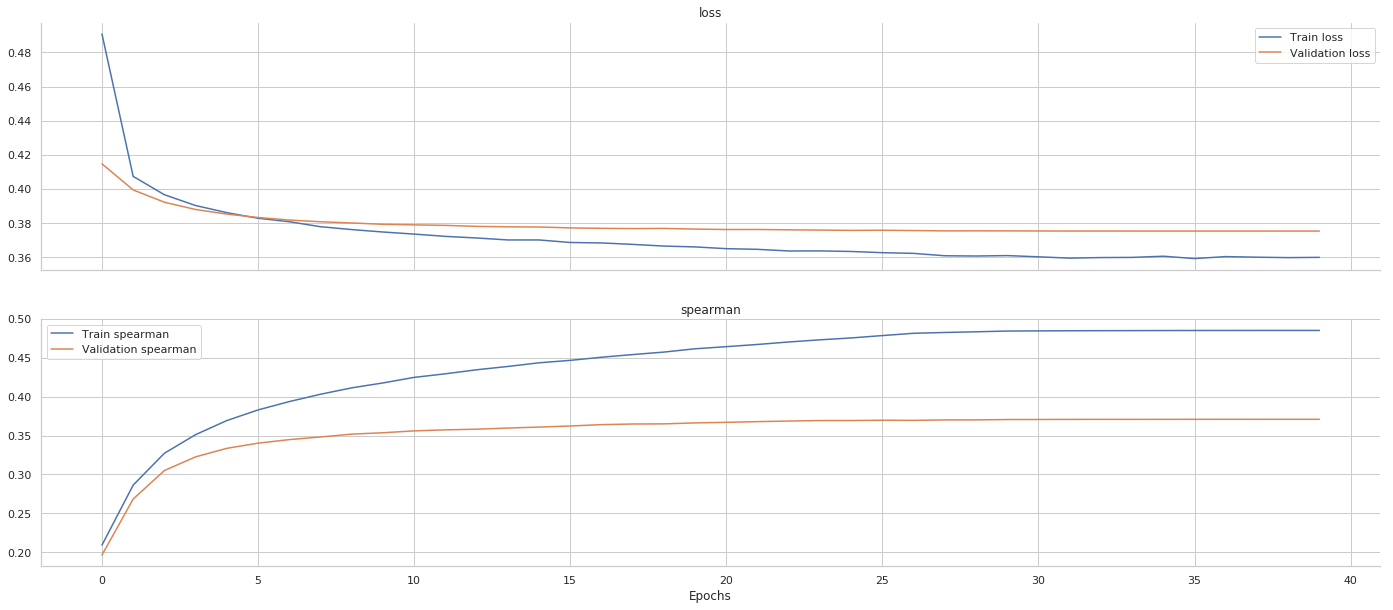

In [11]:
sns.set(style="whitegrid")
for key in spearmanCallback.history.keys():
    history[key] = spearmanCallback.history[key]

plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [12]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))

,Label,Train,Validation
0,Averaged,0.485,0.371
1,question_asker_intent_understanding,0.462,0.400
2,question_body_critical,0.709,0.620
3,question_conversational,0.456,0.404
4,question_expect_short_answer,0.496,0.256
5,question_fact_seeking,0.521,0.344
6,question_has_commonly_accepted_answer,0.547,0.427
7,question_interestingness_others,0.450,0.393
8,question_interestingness_self,0.588,0.528
9,question_multi_intent,0.576,0.424


## By category

In [13]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

,Label,Train (TECHNOLOGY),Validation (TECHNOLOGY),Train (SCIENCE),Validation (SCIENCE),Train (STACKOVERFLOW),Validation (STACKOVERFLOW),Train (LIFE_ARTS),Validation (LIFE_ARTS),Train (CULTURE),Validation (CULTURE)
0,Averaged,0.454,0.339,0.497,0.366,0.384,0.196,0.513,0.405,0.505,0.378


#### Save model weights

In [14]:
model.save_weights(model_path)